# Proyecto - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus


Este proyecto está enfocado en las diferentes técnicas y aplicaciones del procesamiento de lenguaje natural, para lo cual se utilizará la base de datos de Amazon Reviews. Esta base de datos incluye las opiniones (reviews) en español, así como las respectivas puntuaciones que dan los usuarios y clientes respecto a los productos que fueron adquiridos a través de la plataforma. El dataset se puede descargar del siguiente [link](https://drive.google.com/uc?export=download&id=11XnXB7Ubgf3t6gotXGlM4FCwPOMHhDLX).

El **Objetivo** principal de este proyecto será implementar un modelo que permita, a partir de la opinión de un cliente, predecir la cantidad de estrellas con las que finalmente será calificado el producto o servicio.

Para desarrollar este objetivo se construirá un modelo de clasificación de aprendizaje supervisado y para ello se seguirán los siguientes pasos:

1. Instalación e importación de las librerías a utilizar.
1. Análisis exploratorio de datos.
1. Limpieza, transformación y procesamiento de datos haciendo uso de librerías especializadas para el procesamiento de textos, incluyendo la eliminación de stopwords, limpieza y lematización de textos, entre otras.
1. Elaboración del modelo, para ello de realizará lo siguiente:
   * Train test split
   * Implementación de un modelo base o de benchmark para comparar los resultados.
   * Aplicación de métodos de vectorización como TFIDF y BOW
   * Elección de una métrica apropiada de evaluación.
   * Ejecución de varios modelos.
   * Optimización de hiperparámetros.
   * Análisis, comparación de resultados y elección del mejor modelo.
1. Finalmente, se re-planteará el problema de Machine Learning en un problema binario, es decir, se asignarán únicamente las etiquetas Positiva y Negativa a cada crítica para ver cómo se comporta la predicción.
1. Conclusiones Generales.

## 1. Librerías

Librerías a utilizar en este proyecto e instalación:

In [ ]:
#pip install contexto
#pip install stanza
#pip install torch torchvision

In [1]:
# Librerías para tratamiento, limpieza y visualización de datos
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Librerías para procesamiento de texto y modelado: Contexto, Stanza y Sklearn
# Para mayor comprensión, en el transcurso del proyecto se irán importando los módulos a utilizar.

## 2. Análisis Exploratorio de Datos

Carga de datos: se cargan ambos datasets: el de entrenamiento y el de testeo

In [2]:
data_train = pd.read_json('/content/drive/MyDrive/PROYECTO NLP/dataset_es_dev.json', lines= True)
data_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [3]:
data_test = pd.read_json('/content/drive/MyDrive/PROYECTO NLP/dataset_es_test.json', lines= True)
data_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


In [4]:
# Se revisa la forma del dataframe para saber con cuántos datos contamos
data_train.shape, data_test.shape

((5000, 8), (5000, 8))

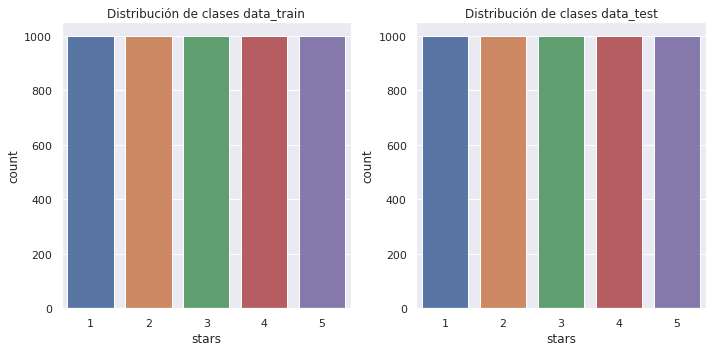

In [5]:
# Se verifica la distribución de la variable a predecir para saber si se tiene un conjunto de datos balanceado

fig, axes = plt.subplots(1,2, figsize=(10, 5)) 

sns.countplot(ax= axes[0], x = data_train.stars)
axes[0].set_title('Distribución de clases data_train')

sns.countplot(ax= axes[1], x = data_test.stars)
axes[1].set_title('Distribución de clases data_test')

plt.tight_layout()
plt.show()

#### **Se concatenan los dataset**

Se unifican el Dataset de Entrenamiento y el Dataset de Testeo

In [6]:
data = pd.concat([data_train,data_test], ignore_index = True )
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [7]:
# Se revisa la forma del nuevo dataset
data.shape

(10000, 8)

In [8]:
# Se verifica si hay valores faltantes
print(data.isna().sum())

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64


#### **Con el proósito de conocer la relevancia de los reviews dentro de las diferentes categorías existentes, ¿Cuántas reviews se tienen por categoría?**

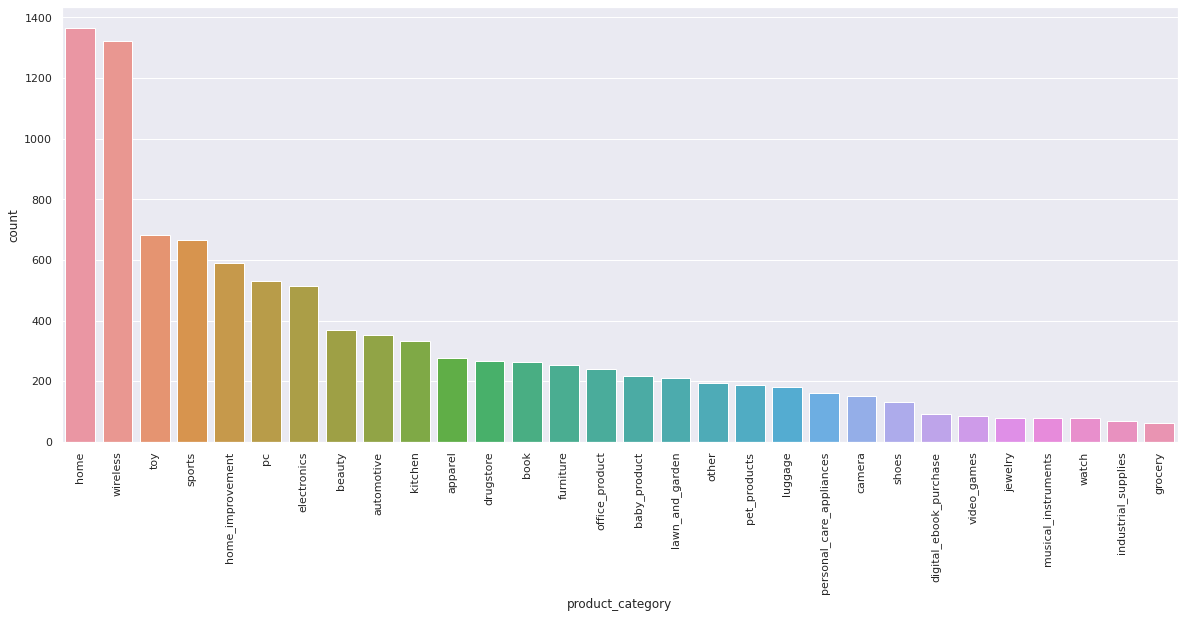

In [9]:
f, ax = plt.subplots(figsize=(20, 8))
plt.xticks(rotation='90')
sns.countplot(data = data, x= "product_category", order = data["product_category"].value_counts().index)
plt.show()

#### **Análisis:**

Definitivamente las categorías  que contienen la mayor cantidad de reviews son las de home y wireless, seguidas de lejos por máximo 5 categorías mas. Por su parte las categorías sobre las cuales los clientes casi no opinan son las de grocery y la de industrial supplies.



#### **¿Cómo son las calificaciones por categoría de producto?:**

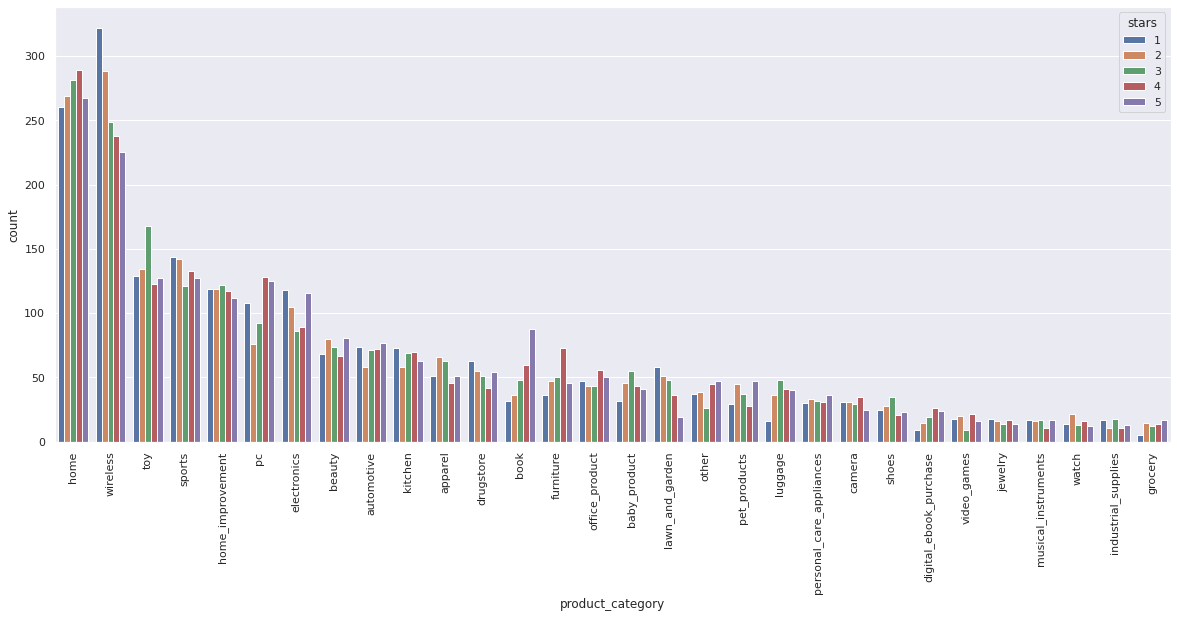

In [10]:
f, ax = plt.subplots(figsize=(20, 8))
plt.xticks(rotation='90')
sns.countplot(data = data, x= "product_category", hue='stars', order = data["product_category"].value_counts().index)
plt.show()

#### **Análisis:**

Esta gráfica nos permite analizar cómo dentro de cada categoría, varía la cantidad de estrellas, es decir, la calificación que el cliente dio al producto o servicio. En la categoría home que es la categoría en la cual existe la mayor cantidad de reviews, puede observarse que la variabilidad entre la cantidad de opiniones con 1 o 5 estrellas, realmente no es mucha, lo que significa que definitivamente las opiniones están muy repartidas entre los que tienen una buena o una mala opinión de los productos. En el caso de wireless, que es la segunda categoría con la mayor cantidad de reviews, es claro que la mayor cantidad de opiniones otorgan una baja calificación por parte de los usuarios. Por otro lado, existen algunas categorías donde definitivamente la tendencia de las opiniones está dirigida más hacia una buena o hacia una mala calificación ya que esto puede observarse por la variación tan grande que existe entre las opiniones de 1 o de 5 estrellas. Por ejemplo, las categorías de books y digital_ebook, la mayor cantidad de reviews son positivas con 4-5 estrellas, lo que representa una muy buena percepción de los productos por parte de los clientes. 




#### **Selección de variables a utilizar**
Dado que para nuestro problema de predicción solo necesitamos la puntuación del número de las estrellas y la columna que contiene el texto de las reviews, se van a extraer del DataFrame solo estas dos columnas para continuar con el trabajo.

In [11]:
data = data[['stars','review_body']].copy()
data.head()

,stars,review_body
0,1,"Malisimo, muy grande demasiado aparatoso y mal..."
1,1,No he recibido el pedido no la devolución
2,1,"Tengo que buscar otro sistema, este no funcion..."
3,1,Utilicé las brocas de menor diámetro y se me d...
4,1,No me gusta su olor a viejo y aspecto malo


Se toma una review para revisar en detalle:

In [12]:
data.iloc[1234].review_body

'La versión anterior tenia muchísimo mejor tacto y mas fiel al original, este parece plástico chino..., el mando funciona perfecto, pero para la compañia que es y lo que cuesta esperaba bastante mas,...'

## 3. Limpieza, transformación y procesamiento de datos

#### **Primera limpieza:**

Se hará una primera limpieza que consiste en eliminar todos los signos de puntuación, dígitos y emoticones presentes en el dataset. Además, con esta función, también se busca hacer algunas correcciones en el texto de palabras con errores tipográficos como son: signos de puntuación entre dos palabras que están juntas, remoción de palabras que tienen más de tres letras juntas y repetidas, eliminación de espacios múltiples y conversión del texto siempre a letras en minúsculas.

In [13]:
re_punc = re.compile("([\"\''().,;:/_¿?¡!—\-])") # Agrega espacios alrededor de la puntuación

re_mult_space = re.compile(r"  *") # Reemplaza multiples espacios con solo uno

# Pattern para remover los emoticones. Referencia: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)


def clean_text1(text):
    text = re_punc.sub(r" \1 ", text) # Agrega espacios alrededor de la puntuación para corregir por ej: pero,no
    text = re.sub('\w*\d\w*', '', text) # Remueve todos los dígitos
    text = emoji_pattern.sub(r'', text) # Remueve todos los emoticones
    # Remueve todas las puntuaciones incluyendo los signos que no están en la librería string y se convierte texto a minúsculas
    text = re.sub('[%s]' % re.escape(string.punctuation + '¡¿°€ª”'), '', text.lower())
    text = re.sub("(.)\\1{2,}", "\\1", text) # Cuando encuentra 3 letras juntas o más, las remueve y deja solo una. Ej: noooo
    text = re_mult_space.sub(' ', text) # Reemplaza multiples espacios con solo uno
    return text

In [14]:
# Se toma un ejemplo para probar la función

clean_text1("400€ muyyyyy carooo ✊ 😜 😡 coordinar por 2ª vez, pero,NO   me gusta")

' muy caro coordinar por vez pero no me gusta'

In [15]:
%%time
# Se aplica la función clean_text1 sobre todo el dataset
data['review_body'] = data['review_body'].apply(lambda x: clean_text1(x))

CPU times: user 668 ms, sys: 2.47 ms, total: 671 ms
Wall time: 674 ms


Se toma un par de reviews para revisar los cambios en detalle:

In [16]:
# se imprime cualquier review para verificar
data.iloc[1234].review_body

'la versión anterior tenia muchísimo mejor tacto y mas fiel al original este parece plástico chino el mando funciona perfecto pero para la compañia que es y lo que cuesta esperaba bastante mas '

In [17]:
# se imprime cualquier review para verificar, esta review tenía un número
data.iloc[0].review_body

'malisimo muy grande demasiado aparatoso y mal protector de pantalla'

#### **Conteo de palabras: ¿Cuántas palabras en total hay en el dataset?**

Para el conteo se va autilizar la función `split()`, la cual permitirá dividir las oraciones en palabras, dando como resultado una lista de palabras. Luego, con la función `len()`se puede calcular el número de total de palabras o tokens.

In [18]:
data['conteo_palabras'] = data['review_body'].apply(lambda x: len(str(x).split()))

In [19]:
data.head()

,stars,review_body,conteo_palabras
0,1,malisimo muy grande demasiado aparatoso y mal ...,10
1,1,no he recibido el pedido no la devolución,8
2,1,tengo que buscar otro sistema este no funciona...,28
3,1,utilicé las brocas de menor diámetro y se me d...,52
4,1,no me gusta su olor a viejo y aspecto malo,10


In [20]:
# Total palabras en todas las reviews
print('Total de palabras en el dataset:', data.conteo_palabras.sum())

Total de palabras en el dataset: 275130


#### **¿Cuál es el promedio de palabras por calificación?**

Con el propósito de determinar si existe una tendencia o una relación directa entre la cantidad de estrellas otorgadas en una review y la cantidad de palabras utilizadas en la misma, se hará una gráfica que permita ver la distribución de palabras utilizadas en los reviews y calcular los promedios de palabras utilizadas, a efectos de poder ver si podríamos tener un elemento adicional de predicción, además del texto.

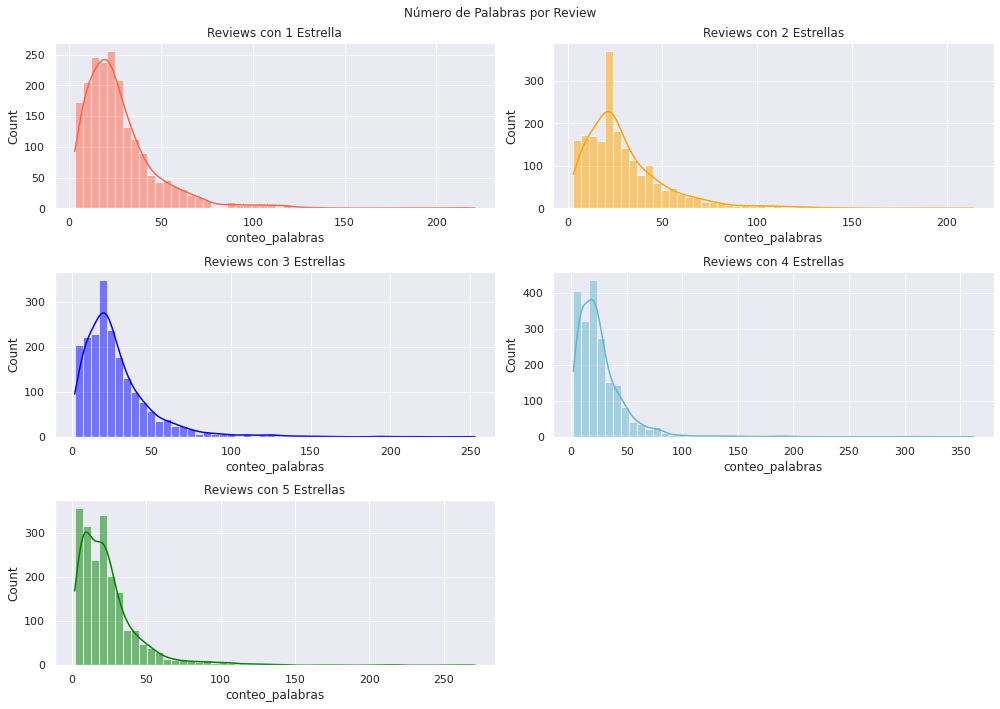

In [21]:
fig,axes = plt.subplots(3,2,figsize=(14,10))
axes = axes.flatten()

data_1_star = data[data['stars']==1]
sns.histplot(ax = axes[0], data= data_1_star, x ='conteo_palabras', color= 'tomato', bins = 50, kde=True)
axes[0].set_title('Reviews con 1 Estrella')

data_2_star = data[data['stars']==2]
sns.histplot(ax = axes[1], data= data_2_star, x ='conteo_palabras', color= 'orange', bins = 50, kde=True)
axes[1].set_title('Reviews con 2 Estrellas')

data_3_star = data[data['stars']==3]
sns.histplot(ax = axes[2], data= data_3_star, x ='conteo_palabras', color= 'blue', bins = 50, kde=True)
axes[2].set_title('Reviews con 3 Estrellas')

data_4_star = data[data['stars']==4]
sns.histplot(ax = axes[3], data= data_4_star, x ='conteo_palabras', color= 'c', bins = 50, kde=True)
axes[3].set_title('Reviews con 4 Estrellas')

data_5_star = data[data['stars']==5]
sns.histplot(ax = axes[4], data=data_5_star, x='conteo_palabras', color= 'green', bins = 50, kde=True)
axes[4].set_title('Reviews con 5 Estrellas')

# Se eliminan los axes vacios
for i in [5]:
    fig.delaxes(axes[i])
    
fig.suptitle('Número de Palabras por Review')
plt.tight_layout()
plt.show()

In [22]:
prom1 = round(data_1_star['conteo_palabras'].mean())
prom2 = round(data_2_star['conteo_palabras'].mean())
prom3 = round(data_3_star['conteo_palabras'].mean())
prom4 = round(data_4_star['conteo_palabras'].mean())
prom5 = round(data_5_star['conteo_palabras'].mean())
print(f'Promedio palabras reviews 1 Estrella: {prom1}')
print(f'Promedio palabras reviews 2 Estrellas: {prom2}')
print(f'Promedio palabras reviews 3 Estrellas: {prom3}')
print(f'Promedio palabras reviews 4 Estrellas: {prom4}')
print(f'Promedio palabras reviews 5 Estrellas: {prom5}')

Promedio palabras reviews 1 Estrella: 28
Promedio palabras reviews 2 Estrellas: 30
Promedio palabras reviews 3 Estrellas: 28
Promedio palabras reviews 4 Estrellas: 26
Promedio palabras reviews 5 Estrellas: 24


#### **Análisis:**

Aunque se pudiera suponer que los clientes utilizarían muchas más palabras cuando dan una mala calificación que cuando dan una buena o una promedio, los resultados muestran que los promedios de palabras utilizadas en los reviews en cada una de las estrellas, fueron prácticamente los mismos. Lo anterior significa que este aspecto no nos servirá de mucho para tener un elemento adicional de predicción fuera del texto.

#### **Stopwords y Frecuencia de Palabras**

Dado que la mayor parte de las librerías reconocidas para procesamiento de texto están mejor desarrolladas para el idioma inglés, se estuvo investigando sobre la existencia de librerías para procesar textos en español y se encontraron las siguientes librerías: [spaCy](https://spacy.io/), [Stanza](https://stanfordnlp.github.io/stanza/) y [ConTexto](https://ucd-dnp.github.io/ConTexto/index.html). Esta última fue desarrollada por el DNP (Departamento Nacional de Planeación de Colombia) y lanzada recientemente en el año 2020.

Para este proyecto se estuvo probando con las tres librerías anteriormente mencionadas y decidió utilizar solo dos de ellas así:

* Se utilizarán las stopwords definidas por ConTexto. En particular esta librería tiene varias listas disponibles para utilizar directamente. Estas listas incluyen: listas de nombres comunes de hombres y mujeres, de apellidos, departamentos y municipios de Colombia, y finalmente una lista de palabras comunes en castellano basada en las stopwords de la librería NLTK.

* Se hará la lematización con Stanza o con ConTexto ya que tienen un performance mejor de acuerdo a las pruebas que se hicieron durante este trabajo. Es importante anotar que el módulo de lematización de ConTexto cuenta con dos lematizadores distintos, los cuales están basados en las librerías de spaCy y Stanza. Estos lematizadores pueden ser utilizados de manera directa a través del módulo `lematizacion` de ConTexto. Más adelante, en este proyecto se mostrará el detalle de la lematización y se aplicará a nuestra base de datos.


#### **Se importan y se listan las stopwords de ConTexto**

In [23]:
# Del módulo limpieza de ConTexto se importa el listado de las stopwords
from contexto.limpieza import lista_stopwords

In [24]:
# Se instancia el objeto, se imprimen las stopwords y se cuentan cuántas palabras contiene la lista
stopwords = lista_stopwords()
print(list(stopwords))
print(len(stopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...


['a', 'ademas', 'además', 'ahi', 'ahí', 'al', 'algo', 'alguna', 'algunas', 'alguno', 'algunos', 'algún', 'alli', 'allí', 'alrededor', 'ambos', 'ante', 'antes', 'aquel', 'aquella', 'aquellas', 'aquello', 'aquellos', 'aquél', 'aquélla', 'aquéllas', 'aquéllos', 'asi', 'así', 'aun', 'aunque', 'aún', 'b', 'c', 'como', 'con', 'contra', 'cual', 'cuales', 'cuando', 'cuál', 'cuáles', 'cómo', 'd', 'de', 'del', 'demás', 'desde', 'donde', 'durante', 'dónde', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'est

[nltk_data]   Unzipping corpora/stopwords.zip.


**Se remueve de las stopwords la palabra 'no'**

In [25]:
stopwords.remove('no')
len(stopwords)

349

**Se agregan unas palabras adicionales a lista de stopwords**

In [26]:
stopwords.append('q')
stopwords.append('pekes')
stopwords.append('xke')
stopwords.append('x')
stopwords.append('xq')
stopwords.append('pq')
stopwords.append('amazon')
stopwords.append('mas')
stopwords.append('hace')
stopwords.append('puede')
stopwords.append('va')
stopwords.append('vez')
stopwords.append('ser')
stopwords.append('queda')
stopwords.append('tal')
stopwords.append('ve')
stopwords.append('pantalla')
stopwords.append('dos')
stopwords.append('sé')
stopwords.append('da')
stopwords.append('después')
stopwords.append('despues')
len(stopwords)

371

#### **Conteo de Stopwords: ¿Cuántas stopwords hay en el dataset?**

En esta sección se hace un conteo de las stopwords por review, seguidamente se suman para conocer cuántas de estas palabras hay en nuestro dataset y además se aplica una función para removerlas.

In [27]:
data['stopwords_conteo'] = data['review_body'].apply(lambda x: len([t for t in x.split() if t in stopwords]))

In [28]:
data.head()

,stars,review_body,conteo_palabras,stopwords_conteo
0,1,malisimo muy grande demasiado aparatoso y mal ...,10,4
1,1,no he recibido el pedido no la devolución,8,3
2,1,tengo que buscar otro sistema este no funciona...,28,12
3,1,utilicé las brocas de menor diámetro y se me d...,52,28
4,1,no me gusta su olor a viejo y aspecto malo,10,4


In [29]:
print('Total de stopwords en el dataset:', data.stopwords_conteo.sum())
print('Total palabras en el dataset sin stopwords:', data.conteo_palabras.sum() - data.stopwords_conteo.sum())

Total de stopwords en el dataset: 143971
Total palabras en el dataset sin stopwords: 131159


In [30]:
%%time
data['review_body'] = data['review_body'].apply(lambda x: " ".join([t for t in x.split() if t not in stopwords]))

CPU times: user 855 ms, sys: 1.95 ms, total: 857 ms
Wall time: 861 ms


In [31]:
# Se toma una review para confirmar que las stopwords fueron eliminadas
data.review_body.loc[1234]

'versión anterior tenia muchísimo mejor tacto fiel original parece plástico chino mando funciona perfecto compañia cuesta esperaba bastante'

**Resultado:** El total de stopwords eliminadas del dataset, corresponden al 52% del total de palabras en el dataset.

#### **Análisis Frecuencia de Palabras y N-gramas**

Con el ejercicio anterior pudimos darnos cuenta que las stopwords representaban el 52% del total de palabras presentes en nuestro dataset, al eliminar estas palabras podemos pasar a hacer una exploración más profunda e identificar de nuestro dataset cuáles son las palabras más frecuentemente utilizadas en todas las reviews. Así mismo, se hará un análisis de la frecuencia por bigramas y trigramas. Este mismo ejercicio se hará para revisar la frecuencia de las palabras para las reviews de 1 y 5 estrellas. 

Para este análisis se utilizará el módulo de `exploracion` de la librería ConTexto que nos permitirá importar las funciones para obtener los unigramas, bigramas y trigramas, las funciones para hacer las gráficas de frecuencias y para realizar nubes de palabras.

In [32]:
from contexto.exploracion import grafica_barchart_frecuencias, obtener_ngramas, nube_palabras

In [33]:
# Se crea una variable 'texto' que nos permite juntar el texto de todas las reviews en uno solo
texto = ' '.join(data['review_body'])
#texto

In [34]:
# Con la función obtener_ngramas se obtienen las listas de unigramas, bigramas y trigramas
unigramas = obtener_ngramas(texto, 1)
bigramas = obtener_ngramas(texto, 2)
trigramas = obtener_ngramas(texto, 3)

#### **Nubes de palabras y n-gramas para todas las reviews**

**Unigramas de todas las reviews**

En la siguiente nube de palabras se observan las 100 palabras más frecuentes en todas las reviews.

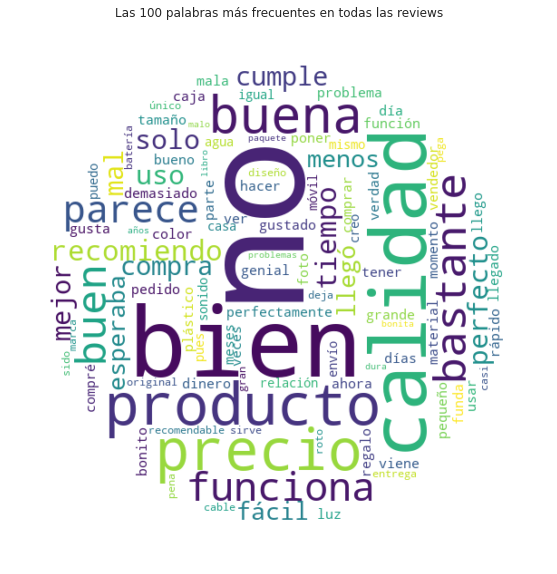

In [37]:
nube_palabras(texto, n_grama=1, titulo='Las 100 palabras más frecuentes en todas las reviews', dim_figura=(10,10))

Se hace una gráfica de barras para observar las frecuencias y las cantidades de las 30 palabras más frecuentes:

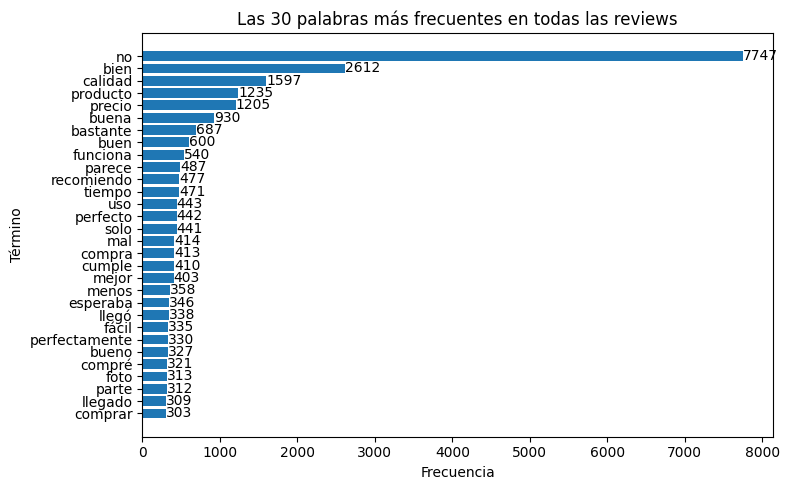

In [38]:
# Esta función permite obtener la gráfica de barras de las 30 palabras más frecuentes en todas las reviews

grafica_barchart_frecuencias(texto, titulo='Las 30 palabras más frecuentes en todas las reviews', dim_figura=(8,5), n_terminos=30)

### Palabras menos frecuentes

Después de explorar las palabras más frecuentes, se listan la cantidad total de palabras para revisar las palabras menos frecuentes y decidir qué cantidad de éstas palabras se podrían eliminar. Esto se hace con el propósito de depurar lo más posible el texto, de forma tal que nuestros modelos sean más precisos.

In [39]:
# Esta línea nos permite dividir el texto completo en palabras y lo pone en una lista
split_texto = texto.split()
#split_texto

In [40]:
freq_words = pd.Series(split_texto).value_counts()

In [41]:
# Lista de palabras más frecuentemente empleadas en las reviews, en orden descendente:
freq_words

no             7747
bien           2612
calidad        1597
producto       1235
precio         1205
               ... 
pellizcarse       1
colorean          1
inox              1
cuticulas         1
sentarla          1
Length: 15306, dtype: int64

In [42]:
# Se imprime la cantidad de palabras únicas
freq_words.shape

(15306,)

In [43]:
# Se vuelve a contar el total de palabras que se tienen
freq_words.sum()

131159

In [44]:
# Cantidad total de palabras que aparecen 1 vez
freq1 = freq_words[freq_words.values == 1]
freq1.sum()

7459

In [45]:
freq1

paragüero       1
innovador       1
probara         1
priorizar       1
revomendable    1
               ..
pellizcarse     1
colorean        1
inox            1
cuticulas       1
sentarla        1
Length: 7459, dtype: int64

In [46]:
# Cantidad total de palabras que aparecen de 1 a 20 veces 
freq20 = freq_words[freq_words.values <= 20]
freq20.sum()

41981

In [47]:
freq20

unidad         20
lejos          20
motivo         20
queja          20
pésima         20
               ..
pellizcarse     1
colorean        1
inox            1
cuticulas       1
sentarla        1
Length: 14243, dtype: int64

#### **Se eliminan todas las palabras que aparecen menos de 20 veces**

Teniendo en cuenta que el número de palabras resultantes que tenemos hasta ahora es de 131.159, se eliminarán aquellas palabras muy poco empleadas en las reviews y para ello se asumió que aquellas palabras que aparecen entre 1 y 20 veces podrían eliminarse toda vez que es un rango razonable, por ser poco representativo respecto a la base total de 131.159. Por ejemplo, si se toma la palabra que más se repite dentro del rango de 20 solo representa el 0,015% del total de todas las palabras en el texto.

In [48]:
%%time 
data['review_body'] = data['review_body'].apply(lambda x: " ".join([t for t in x.split() if t not in freq20]))

CPU times: user 191 ms, sys: 1.94 ms, total: 193 ms
Wall time: 200 ms


In [49]:
data['segundo_conteo_palabras'] = data['review_body'].apply(lambda x: len(str(x).split()))

In [50]:
# Nuevo total de palabras
data.segundo_conteo_palabras.sum()

89178

#### **Bigramas todas las reviews**

Continuando con nuestra exploración, se realiza un gráfico de barras con los 30 bigramas más frecuentes en todo el dataset.

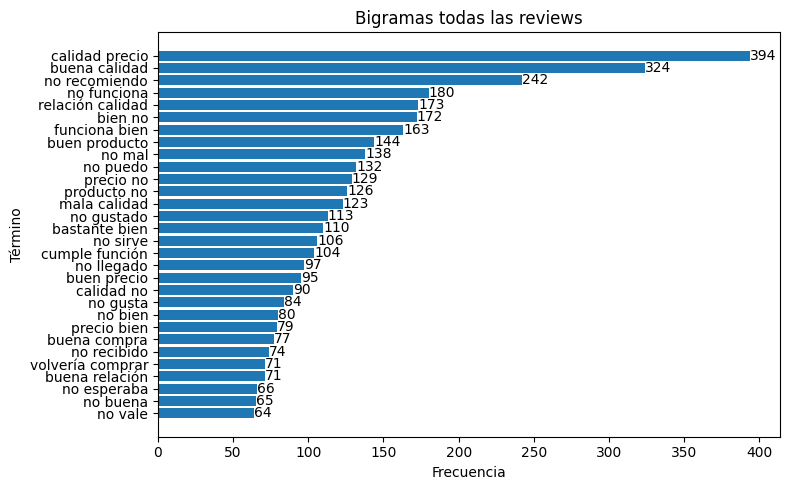

In [51]:
grafica_barchart_frecuencias(texto, n_grama=2, dim_figura=(8,5), titulo = "Bigramas todas las reviews", n_terminos=30)

#### **Trigramas todas las reviews**

De igual manera se realiza gráfica de barras con los 30 trigramas más frecuentes en todo el dataset.

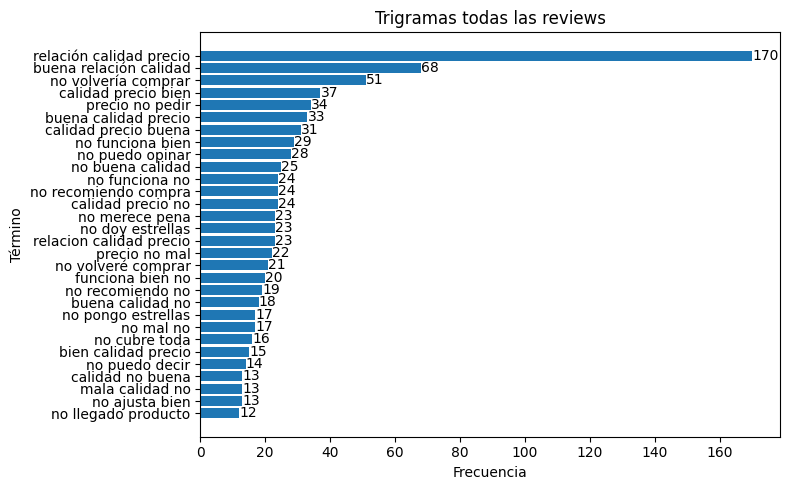

In [52]:
grafica_barchart_frecuencias(texto, n_grama=3, dim_figura=(8,5), titulo = "Trigramas todas las reviews", n_terminos=30)

#### **Exploración de n-gramas para reviews con 5 Estrellas**

Se toma del dataset las reviews de 5 estrellas para obtener los unigramas, bigramas y trigramas.

In [53]:
data_5_star = data[data['stars']==5]
data_5_star.head(2)

,stars,review_body,conteo_palabras,stopwords_conteo,segundo_conteo_palabras
4000,5,encantada práctico útil foto fácil único falta...,49,32,11
4001,5,cuanto compré,12,6,2


In [54]:
# Se crea una variable 'texto5' que nos permite juntar todo el texto de las reviews con 5 estrellas
texto5 = ' '.join(data_5_star['review_body'])
#texto5

In [55]:
# Se obtiene listas de unigramas, bigramas y trigramas
unigramas5 = obtener_ngramas(texto5, 1)
bigramas5 = obtener_ngramas(texto5, 2)
trigramas5 = obtener_ngramas(texto5, 3)

#### **Unigramas reviews 5 estrellas**

En la siguiente nube de palabras se observa las 100 palabras más frecuentes en las reviews de 5 Estrellas.

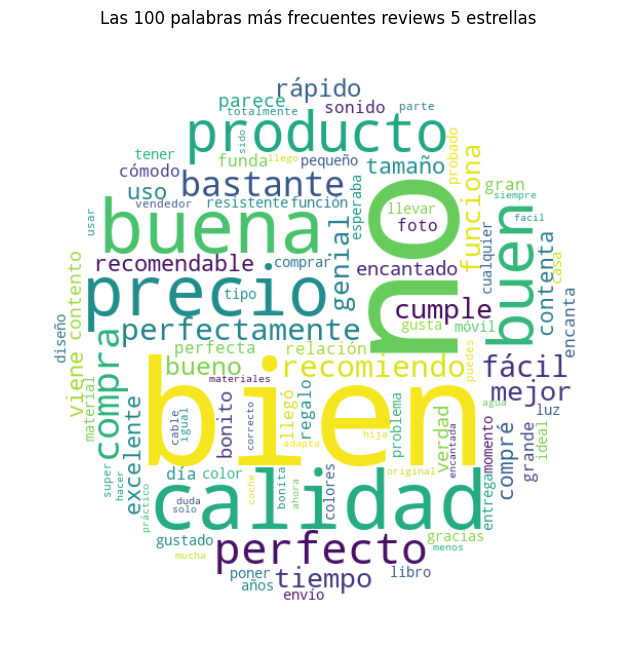

In [56]:
nube_palabras(texto5, n_grama=1, titulo='Las 100 palabras más frecuentes reviews 5 estrellas', semilla=1234, dim_figura=(8,8))

Se hace una gráfica de barras para observar las frecuencias y las cantidades de las 30 palabras más frecuentes

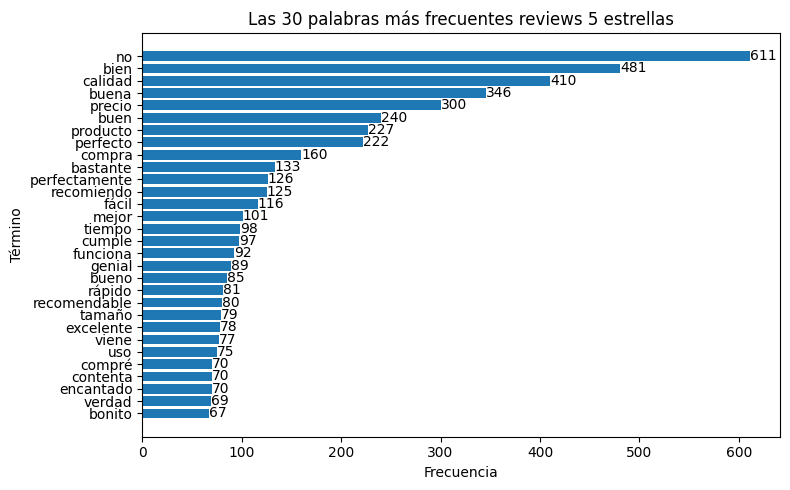

In [57]:
# Gráficas de barras con las frecuencias
grafica_barchart_frecuencias(texto5, titulo='Las 30 palabras más frecuentes reviews 5 estrellas', dim_figura=(8,5), n_terminos=30)

#### **Bigramas reviews 5 estrellas**

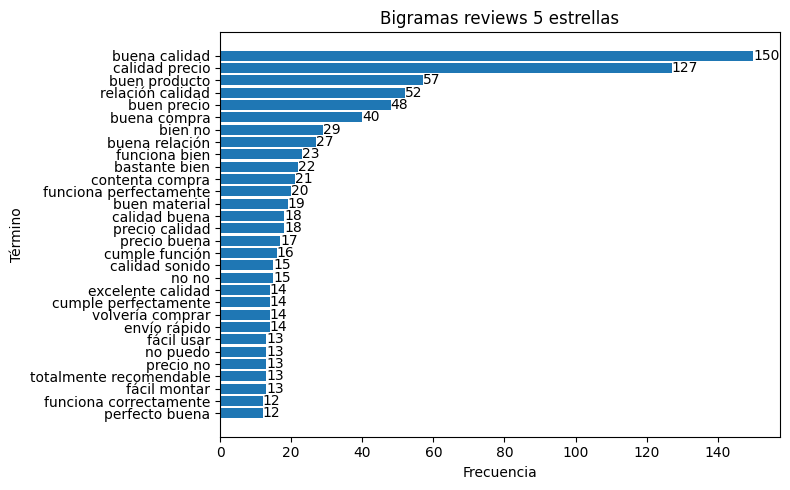

In [58]:
grafica_barchart_frecuencias(texto5, n_grama=2, dim_figura=(8,5), titulo = "Bigramas reviews 5 estrellas", n_terminos=30)

#### **Trigramas reviews 5 estrellas**

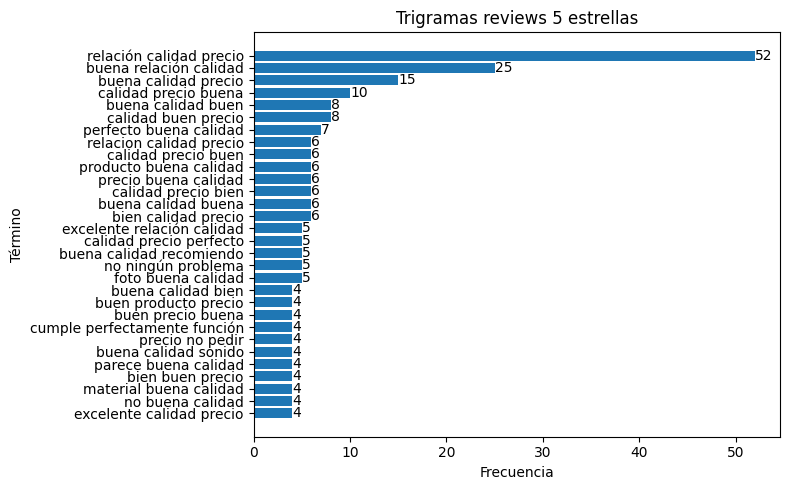

In [59]:
grafica_barchart_frecuencias(texto5, n_grama=3, dim_figura=(8,5), titulo = "Trigramas reviews 5 estrellas", n_terminos=30)

#### **Exploración de n-gramas para reviews con 1 Estrella**

Se realiza el mismo ejercicio para explorar la frecuencia de unigramas, bigramas y trigramas en las reviews de 1 Estrella.

In [60]:
data_1_star = data[data['stars']==1]
data_1_star.head(2)

,stars,review_body,conteo_palabras,stopwords_conteo,segundo_conteo_palabras
0,1,grande demasiado mal protector,10,4,4
1,1,no recibido pedido no devolución,8,3,5


In [61]:
# se crea una variable 'texto' que nos permite juntar todo el texto de las reviews
texto1 = ' '.join(data_1_star['review_body'])
#texto5

In [62]:
# Obtener listas de palabras, bigramas y trigramas más frecuentes
unigramas1 = obtener_ngramas(texto1, 1)
bigramas1 = obtener_ngramas(texto1, 2)
trigramas1 = obtener_ngramas(texto1, 3)

#### **Unigramas reviews 1 estrella**

En la siguiente nube de palabras se observa las 100 palabras más frecuentes en todas las reviews.

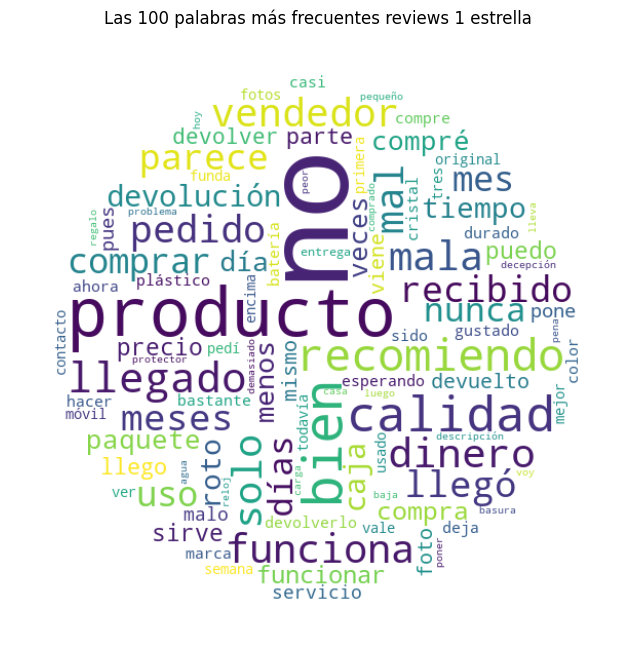

In [63]:
nube_palabras(texto1, n_grama=1, titulo='Las 100 palabras más frecuentes reviews 1 estrella', semilla=1234, dim_figura=(8,8))

Se hace una gráfica de barras para observar las frecuencias y las cantidades de las 30 palabras más frecuentes

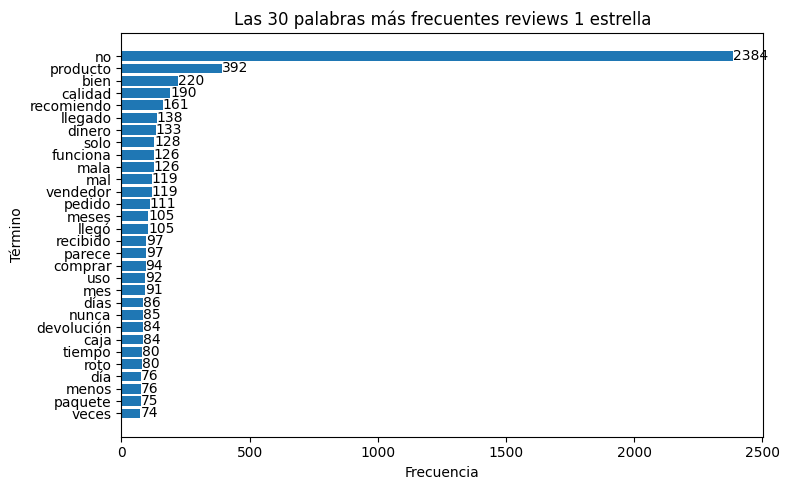

In [64]:
# Gráficas de barras con las frecuencias
grafica_barchart_frecuencias(texto1, titulo='Las 30 palabras más frecuentes reviews 1 estrella', dim_figura=(8,5), n_terminos=30)

#### **Bigramas reviews 1 estrella**

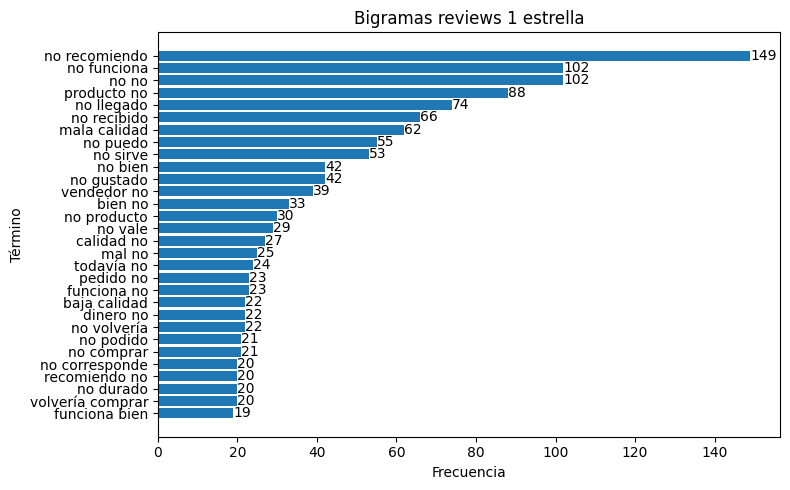

In [65]:
grafica_barchart_frecuencias(texto1, n_grama=2, dim_figura=(8,5), titulo = "Bigramas reviews 1 estrella", n_terminos=30)

#### **Trigramas reviews 1 estrellas**

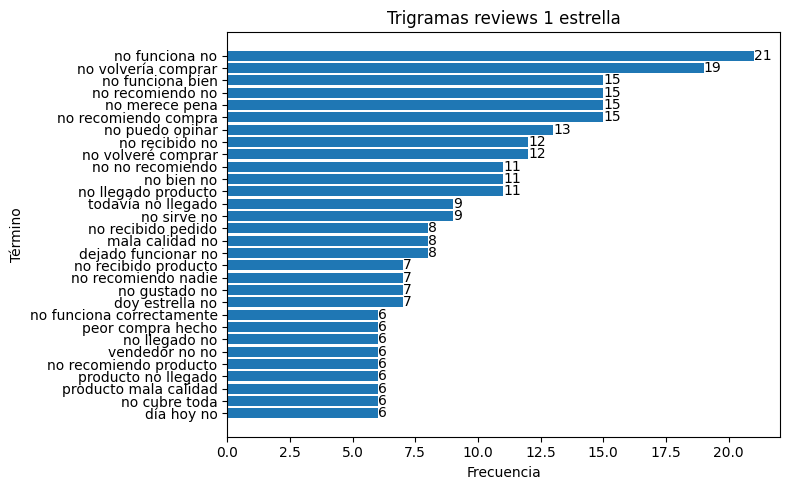

In [66]:
grafica_barchart_frecuencias(texto1, n_grama=3, dim_figura=(8,5), titulo = "Trigramas reviews 1 estrella", n_terminos=30)

#### **Comparación frecuencia de palabras para las reviews de 1 y 5 estrellas**

Para comodidad se hace una tabla para visualizar y comparar las 30 palabras más frecuentes en las reviews de 1 y 5 Estrellas.

In [67]:
freq_1star = pd.Series(unigramas1).value_counts()
freq_1star = freq_1star[:30]

In [68]:
freq_5star = pd.Series(unigramas5).value_counts()
freq_5star = freq_5star[:30]

In [69]:
comparacion = {'freq_1star': freq_1star,
               'freq_5star' : freq_5star,}
comparacion = pd.DataFrame(comparacion, columns = ['freq_1star', 'freq_5star'])
comparacion.sort_values(by = ["freq_5star", "freq_1star"], ascending= False)

,freq_1star,freq_5star
no,2384.0,611.0
bien,220.0,481.0
calidad,190.0,410.0
buena,NaN,346.0
precio,NaN,300.0
buen,NaN,240.0
producto,392.0,227.0
perfecto,NaN,222.0
compra,NaN,160.0
bastante,NaN,133.0


#### **Segunda limpieza: Se quitan las tildes y luego se lematiza:**

Con el propósito de depurar aún más el dataset y de evitar que el lematizador cometa errores con aquellas palabras que deberían tener tilde y no la tienen, se procede a realizar la segunda limpieza, la cual consiste en quitar las tildes y lematizar. La mayoría de las personas hoy en día acostumbran a escribir sin tildes, por consiguiente para efectos de la depuración, es mejor quitar todas las tildes de los reviews, independientemente de que al hacerlo, el lematizador pueda cometer errores. El modelo no maneja el concepto del "significado de las palabras" sino que traduce las palabras a vectores de números, por lo tanto es importante que durante la vectorización, el modelo identifique adecuadamente la frecuencia de las palabras que aparecen en el corpus para predecir.

In [70]:
from unicodedata import normalize

def clean_text2(text):
    # Se reemplazan todas las letras que tienen tilde por letras sin tilde 
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize( "NFD", text), 0, re.I)
    text = normalize( 'NFC', text)
    return text

In [71]:
# Se toma un ejemplo para hacer una prueba de la función
clean_text2("esta función debe quitar tildes PERO NO eñes á, é, í, ó, ú, Á, É, Í, Ó, Ú, EÑE...")

'esta funcion debe quitar tildes PERO NO eñes a, e, i, o, u, A, E, I, O, U, EÑE...'

#### **Se aplica la función de limpieza sobre todas las reviews:**

In [72]:
%%time
data['review_body'] = data['review_body'].apply(lambda x: clean_text2(x))

CPU times: user 123 ms, sys: 35 µs, total: 123 ms
Wall time: 125 ms


Se toma una review para revisar los cambios en detalle:

In [73]:
data.iloc[1234].review_body

'anterior tenia muchisimo mejor tacto original parece plastico chino mando funciona perfecto cuesta esperaba bastante'

### Lematización

Como se mencionó al comienzo, para efectos de este proyecto se utilizarán 2 librerías que son ConTexto y Stanza. En esta sección se realizaran unas pruebas utilizando la función de lematización de ConTexto con Stanza y luego se hará la lematización directamente con la librería Stanza, con el objetivo de explorar si el resultado en ambos casos es el mismo. Adicionalmente se hará una prueba para mostrar que el lematizador aplica la función a aquellas palabras que están bien escritas, lo cual se podrá ver más abajo, donde se incluye el ejemplo con las palabras "debería" y "tendría".

#### **Se prueba la lematización con ConTexto**

In [74]:
from contexto.lematizacion import LematizadorStanza
from contexto.lematizacion import lematizar_texto
import stanza

In [75]:
%%time
texto = 'malísima calidad engaño usos roto exijo devuelvan dinero estafadores. Precio, incluyo palabras sin tilde: debería, tendría, deberia, tendria'
ejemplo = lematizar_texto(texto, libreria='stanza', limpiar = False)
print(ejemplo)

[INFO] Descargando modelo. Este proceso puede tardar varios minutos.

malísimo calidad engaño uso roto exigir devolver dinero estafador . precio , incluir palabra sin tilde : deber , tener , deberia , tener
CPU times: user 10.3 s, sys: 3.83 s, total: 14.2 s
Wall time: 1min 5s


#### **Se prueba la lematización con Stanza**

In [76]:
# Se descarga el paquete para el lenguaje español
# Se instancia un objeto nlp_st
stanza.download('es', package='ancora', processors='tokenize,mwt,pos,lemma')
nlp_st = stanza.Pipeline(processors='tokenize,mwt,pos,lemma',lang='es')

In [77]:
# Se construye una función para la lematización
def lematizacion(text):
    doc = nlp_st(text)
    return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])

In [78]:
%%time
lematizacion('malísima calidad engaño usos roto exijo devuelvan dinero estafadores. Precio, incluyo palabras sin tilde: debería, tendría, deberia, tendria')

CPU times: user 84.9 ms, sys: 411 µs, total: 85.3 ms
Wall time: 89.5 ms


'malísimo calidad engaño uso roto exigir devolver dinero estafador . precio , incluir palabra sin tilde : deber , tener , deberia , tener'

**Conclusión:**

Se observa que al utilizar cualquiera de las dos librerías se obtiene el mismo resultado, además se observa que el lematizador sí funciona con las palabras que están correctamente escritas con tilde pero puede fallar y no lematizar aquellas palabras sin tilde, ya que no las identifica. Por ejemplo: la palabra "deberia" (sin tilde), no se lematizó, por esta razón se quitaron todas las tildes antes de aplicar la lematización pues como ya se ha dicho, lo que nos interesa es la frecuencia de las palabras.

## 4. Implementación de modelos

#### **Train test split**

Se hace el train test split donde se asigna 70% de los datos para entrenar y 30% de los datos para testeo.

In [79]:
# Se asigna a "X" la variable independiente y a "y" la variable target 
X = data['review_body']
y = data['stars']

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000,), (3000,), (7000,), (3000,))

#### **Se aplica la lematización sobre cada conjunto de test y el conjunto de train**

In [81]:
%%time

# Se instancia directamente el lematizador de Stanza de la librería Contexto con el lenguaje de español
lematizador = LematizadorStanza('es')

# Se aplica la función de lematización sobre X_test
Xtest_lemma = [lematizar_texto(i,lematizador=lematizador, limpiar = False) for i in X_test]

CPU times: user 2min 41s, sys: 1.47 s, total: 2min 43s
Wall time: 2min 43s


In [82]:
# Se imprime el texto lematizad: se ve que el resultado es una lista de oraciones y se observa que la lematización fue aplicada
Xtest_lemma

['comprar protector solo pegar marco negro borde poco hora',
 'bastante bien precio buen calidad bastante practicar traer varios accesorio poder camara buen calidad precio',
 'producto decir funda silicona proteger camara decepcion ser funda no ninguno tipo embalaje',
 'practico sonido precio',
 'perfecto buen material no salir primero momento medida perfecto lugar',
 'horrible apenas semana punta no traer',
 'vez no camar cargador',
 'no recibir pedido nadie dar ninguno pasado pedido pues dia gracias',
 'decir pensar cristal templado fino plastico tipo protector llevar no seguridad',
 'ver foto no buen cosa usado uno vez ir devolucion bastante',
 'no cuanto tiempo precio no poder facil montar quedar bien querer no poder montar inferior pegar pared',
 'precio comprar mejor calidad solo venir poner color dar lugar venir varios no comodo abrir',
 'dar mano ver color venir foto encima llevar medio hora todavia estar',
 'no funcionar completamente bateria luz no cargar',
 'buen regalo colo

In [83]:
type(Xtest_lemma)

list

In [84]:
# Se convierte el X_train lematizado a una serie de pandas
Xtest= pd.Series(Xtest_lemma)

In [85]:
Xtest

0       comprar protector solo pegar marco negro borde...
1       bastante bien precio buen calidad bastante pra...
2       producto decir funda silicona proteger camara ...
3                                  practico sonido precio
4       perfecto buen material no salir primero moment...
                              ...                        
2995                                          exactamente
2996    bote bastante pues no buscar aceite no cumplir...
2997                                ir mejor medida menos
2998    realmente no no dejar ventilador potente no po...
2999                    comprar pieza solo utilizado bien
Length: 3000, dtype: object

In [86]:
%%time
# Se aplica la función de lematización sobre X_train
Xtrain_lemma = [lematizar_texto(i, lematizador=lematizador, limpiar = False) for i in X_train]

CPU times: user 6min 18s, sys: 3.28 s, total: 6min 22s
Wall time: 6min 22s


In [88]:
# Se convierte el X_train lematizado a una serie de pandas
Xtrain = pd.Series(Xtrain_lemma)

In [89]:
Xtrain

0               regalo niño vino pack no haber usar parte
1       espacio grande impermeable usar llevar materia...
2       llevar tiempo usar bolsa parecer funcionar no ...
3                  llegado tiempo caja no embalaje regalo
4       no llegar nunca producto mes esperar final dev...
                              ...                        
6995    no comentario sorpresa no leer comentario no u...
6996    año mes uso formar vez mes pues dejar funciona...
6997    sentir mal resultado envio tiempo hecho perder...
6998                            cristal llegado no iphone
6999    tamaño bien esperar poner perder aire no cabo ...
Length: 7000, dtype: object

In [90]:
# Se importan las librerías que se utilizarán en esta sección

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedKFold

## **Vectorización y modelos**

En esta sección se hará un estudio del performance de diferentes modelos utilizando dos métodos de vectorización: el método TF-IDF (Term Frequency - Inverse Document Frequency) y el método de vectorización BOW (Bags of Words). Esto con el objetivo de comparar cuál método funciona mejor y además concluir qué modelo tiene mejor performance.

Recordemos que el método **TF-IDF** permite en primera instancia identificar cuántas veces aparece un término en un documento (esto es TF), así pues, mientras más veces aparece un término, más importante es dentro del documento y recibe mayor puntaje. Luego, como se sabe, dentro de un documento pueden existir palabras que tienen una alta frecuencia en todos los textos, o en nuestro caso, en todas las reviews. Cuando a todas las palabras que se repiten con frecuencia en todas las reviews se le asignan un puntaje alto, no se gana mucha información diferenciada que le permita al modelo clasificar entre una clase u otra, es decir, que será muy difícil determinar si una review pertenece a una calificación de 1, 2, 3 , 4 o 5 estrellas. En este punto entra en juego la parte de IDF de la función TF-IDF, ésta permite que se compare la frecuencia de una palabra en una review con respecto a todas las reviews del datset. En este caso, a mayor frecuencia de la palabra en todas las reviews del dataset, se le asignará menor puntaje. Así se evita puntuar alto palabras que no agreguen información y el modelo podrá diferenciar con mayor precisión si una review es buena o mala. TF-IDF crea una matriz en la que cada columna es un término, cada fila una review.

En el caso del método **BOW**, éste permite identificar la presencia de palabras dentro de cada review. Para cada palabra que aparece le asigna el número 1 y para las palabras ausentes en la review le asigna el número 0. Éste almacena en una matriz el número de veces que aparece cada palabra en todo el texto de todas las reviews y es así como el modelo podrá predecir a cuál categoría pertenece una review.


#### **Métrica de evaluación**

La métrica de evaluación seleccionada será: **accuracy**, el resultado de esta métrica se calcula dividiendo el número de predcciones correctas realizadas por el modelo sobre el número total de registros. El mejor resultado es 100%, lo que indicaría que todas las predicciones son correctas. Se elegió esta metrica porque como se vió al principio de este proyecto, nuestros datos están balanceados. Es importante tener en cuenta que esta métrica no es una medida válida del rendimiento de un modelo cuando se tiene un conjunto de datos desbalanceado.


### **Vectorización TF-IDF y modelos:**

#### **Modelo Base: LinearSVC**

Con base en lo anterior, se procederá a ejecutar un modelo base o de benchmark, el cual nos servirá de comparación. Para este caso se utilizará el modelo más sencillo de SVC (Linear Support Vector Classification), que es utilizando un kernel lineal, lo que significa que el límite de decisión es una línea recta. Este tipo de modelos pocas veces se utilizan en la práctica ya que el comportamiento de las variables en la vida real no es líneal, sin embargo, justamente por su sencilléz se va a utilizar como modelo base de comparación, ya que es la versión más simple de SVC.

De aquí en adelante se utilizarán Pipelines de procesamiento, en el que se incluyen el vectorizador TF-IDF y el modelo. Para este primer procesamiento, la vectorización se hará con unigramas.

In [91]:
# Se instancia TF-IDF teniendo en cuenta unigramas 
# Se instancia el clasificador SVC lineal
# Se crea un pipeline para procesar lo anterior
clf = Pipeline([('tfidf', TfidfVectorizer()), ('svc_clf', LinearSVC())], verbose=3)

# Se hace el ajuste sobre los datos de entrenamiento lematizados y sobre los datos de target de entrenamiento
clf.fit(Xtrain, y_train)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing svc_clf, total=   0.1s


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc_clf', LinearSVC())],
         verbose=3)

In [92]:
# Se hacen las predicciones sobre los datos de testeo lematizados
y_pred = clf.predict(Xtest)

In [93]:
# Se imprime el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.53      0.62      0.57       608
           2       0.33      0.29      0.31       600
           3       0.32      0.31      0.31       580
           4       0.41      0.32      0.36       627
           5       0.48      0.59      0.53       585

    accuracy                           0.42      3000
   macro avg       0.41      0.43      0.42      3000
weighted avg       0.41      0.42      0.42      3000



**Conclusión:** En este primer modelo se obtiene una predicción del 42%. Para el caso de las reviews de 1 estrella se obtuvo una "precision" del 53%, lo que quiere decir que nuestro modelo logra predecir un poco más de la mitad de las reviews para 1 estrella de manera correcta y la otra mitad de manera incorrecta. Lo mismo sucede para el caso de las de 5 estrellas fue del 48%.

#### **Segundo modelo:**

En esta ocasión se hace un segundo modelo base utilizando LinearSVC, pero esta vez se prueba el método TF-IDF con unigramas y bigramas para ver cómo se comporta el resultado.

In [94]:
# Se instancia TF-IDF tomando en cuenta unigramas y bigramas
# Se instancia el clasificador SVC lineal
# Se crea un pipeline para procesar lo anterior
clf1 = Pipeline([('tfidf_ngram', TfidfVectorizer(ngram_range=(1,2))), ('svc_clf1', LinearSVC())], verbose=3)

# Se hace el ajuste sobre los datos de entrenamiento lematizados y sobre los datos de target de entrenamiento
clf1.fit(Xtrain, y_train)

[Pipeline] ....... (step 1 of 2) Processing tfidf_ngram, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing svc_clf1, total=   0.2s


Pipeline(steps=[('tfidf_ngram', TfidfVectorizer(ngram_range=(1, 2))),
                ('svc_clf1', LinearSVC())],
         verbose=3)

In [95]:
# Se hacen las predicciones sobre los datos de testeo lematizados
y_pred1 = clf1.predict(Xtest)

In [96]:
# Se imprime el reporte de clasificación
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           1       0.53      0.62      0.57       608
           2       0.32      0.29      0.31       600
           3       0.33      0.31      0.32       580
           4       0.43      0.32      0.37       627
           5       0.48      0.61      0.54       585

    accuracy                           0.43      3000
   macro avg       0.42      0.43      0.42      3000
weighted avg       0.42      0.43      0.42      3000



**Conclusión:** Para este segundo modelo base, se observa que el cambio de la vectorización al utilizar unigramas y bigramas no altera mucho el resultado final de la predicción, ya que como se observa se obtiene una predicción del 43% (un punto porcentual más que el anterior modelo).

#### **Tercer modelo:**

Se realiza un tercer modelo base utilizando LinearSVC, pero esta vez se prueba el método TF-IDF solo con bigramas para ver cómo se comporta el resultado.

In [97]:
# Se instancia TFIDF tomando en cuenta bigramas
# Se instancia el clasificador SVC lineal
# Se crea un pipeline con lo anterior
clf2 = Pipeline([('tfidf_ngram2', TfidfVectorizer(ngram_range=(2,2))), ('svc_clf2', LinearSVC())], verbose=3)

# Se hace el ajuste sobre los datos de entrenamiento lematizados y sobre los datos de target de entrenamiento
clf2.fit(Xtrain, y_train)

[Pipeline] ...... (step 1 of 2) Processing tfidf_ngram2, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing svc_clf2, total=   0.2s


Pipeline(steps=[('tfidf_ngram2', TfidfVectorizer(ngram_range=(2, 2))),
                ('svc_clf2', LinearSVC())],
         verbose=3)

In [98]:
# Se hacen las predicciones sobre los datos de testeo lematizados
y_pred2 = clf2.predict(Xtest)

In [99]:
# Se imprime el reporte de clasificación
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           1       0.48      0.53      0.51       608
           2       0.30      0.26      0.28       600
           3       0.26      0.23      0.24       580
           4       0.37      0.27      0.31       627
           5       0.40      0.57      0.47       585

    accuracy                           0.37      3000
   macro avg       0.36      0.37      0.36      3000
weighted avg       0.36      0.37      0.36      3000



**Conclusión:** En este tercer modelo base en el que se utiliza la vectorización TF-IDF solo con bigramas, se observa que la predicción desmejora completamente bajando hasta un 37%. Por lo que se concluye que el modelo predice peor cuando solo se utilizan bigramas. 

#### **Optimización de hiperparámetros con GridSearchCV:** 

**Modelo RandomForest Classifier**

Luego de correr nuestro modelo base y de identificar la mejor manera de vectorizar con TF-IDF en nuestro dataset, se hará una optimización de hiperparámetros utilizando un modelo de  Random Forest Classifier y una vectorización TF-IDF, teniendo en cuenta unigramas y bigramas.

In [100]:
# Se instancia TF-IDF tomando en cuenta unigramas y bigramas
# Se instancia el modelo RandomForest Classifier
# Se crea un Pipeline de procesamiento con lo anterior

pipe_rfc = Pipeline(steps=[('tfidf_rfc', TfidfVectorizer(ngram_range=(1,2))),
                           ('clf_rfc', RandomForestClassifier(random_state=123))])

# Parámetros a optimizar
params_rfc = {'clf_rfc__n_estimators': [20,50],
              'clf_rfc__max_features':[5, 10, 20],
              'clf_rfc__max_depth': [None, 3, 10, 20],
              'clf_rfc__criterion': ['gini', 'entropy']}

# Validación Cruzada

grid_rfc = GridSearchCV(
    estimator = pipe_rfc,
    param_grid = params_rfc,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
    refit = True, 
    verbose = 3,
    return_train_score = True
)


grid_rfc.fit(Xtrain, y_train)

Fitting 15 folds for each of 48 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 19.7min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=Pipeline(steps=[('tfidf_rfc',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('clf_rfc',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'clf_rfc__criterion': ['gini', 'entropy'],
                         'clf_rfc__max_depth': [None, 3, 10, 20],
                         'clf_rfc__max_features': [5, 10, 20],
                         'clf_rfc__n_estimators': [20, 50]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [101]:
# Mejores hiperparámetros por validación cruzada
print("Mejores hiperparámetros encontrados por validación cruzada")
print(grid_rfc.best_params_, ":", grid_rfc.best_score_, grid_rfc.scoring)

Mejores hiperparámetros encontrados por validación cruzada
{'clf_rfc__criterion': 'gini', 'clf_rfc__max_depth': None, 'clf_rfc__max_features': 20, 'clf_rfc__n_estimators': 50} : 0.402 accuracy


In [102]:
modelo_final_rfc = grid_rfc.best_estimator_

In [103]:
# Error de test del modelo final
y_pred_rfc = modelo_final_rfc.predict(Xtest)

In [104]:
# Se imprime el reporte de clasificación
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           1       0.48      0.63      0.55       608
           2       0.30      0.25      0.28       600
           3       0.29      0.29      0.29       580
           4       0.40      0.28      0.33       627
           5       0.46      0.55      0.50       585

    accuracy                           0.40      3000
   macro avg       0.39      0.40      0.39      3000
weighted avg       0.39      0.40      0.39      3000



**Conclusión:** Empleando un modelo de RandomForest y validación cruzada los mejores hiperparámetros son:
* criterion = gini (La función para medir la calidad de una división)
* max_depth:None (La profundidad máxima del árbol. Si es None, los nodos se expanden hasta que todas las hojas sean puras)
* max_features= 20 (cantidad de características o palabras que utliza para predecir)
* n_estimators= 50 (la cantidad de árboles)  

Con estos hiperparámetros se consigue una predicción de tan solo el 40%, la cual es bastante baja.

#### **Importancia de predictores**

El modelo de RandomForest permite identificar qué información o qué palabras o bigramas está utilizando para predecir. En este caso se mostrarán las 30 primeras palabras o bigramas que el modelo utiliza.

In [105]:
feature_importances = grid_rfc.best_estimator_._final_estimator.feature_importances_
feature_importances 

array([2.26856251e-04, 7.39647795e-06, 2.32257590e-06, ...,
       2.50815454e-05, 0.00000000e+00, 1.32927671e-05])

In [106]:
# Se crea la matriz de features 
tfidf_rfc = TfidfVectorizer(ngram_range=(1,2))
feature_matrix = tfidf_rfc.fit_transform(Xtrain)

# Se muestra la matriz de features 
feature_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [107]:
# Se crea un DataFrame con la importancia de cada feature (unigramas o bigramas de palabras) para el modelo y se imprimen las primeras 30
importancia_predictores = pd.DataFrame(
                            {'predictor': tfidf_rfc.get_feature_names(),
                             'importancia': feature_importances}
                            )
print("Importancia de los predictores en el modelo")
importancia_predictores.sort_values('importancia', ascending=False).head(30)

Importancia de los predictores en el modelo


,predictor,importancia
18345,no,0.017377
1908,bien,0.007778
2809,buen,0.007639
21210,perfecto,0.005754
3564,calidad,0.004743
15128,llegar,0.004162
23476,producto,0.003989
22759,precio,0.003937
20789,pequeño,0.003027
6987,cumplir,0.002867


#### **Optimización de hiperparámetros con GridSearchCV:** 

**Modelo: SVC utilizando Kernel RBF (Radial Basis Function)**

Se retoma el modelo SVC, pero esta vez utilizando el kernel RBF. El algoritmo de support vector machine es uno de los algoritmos de aprendizaje supervisado más utilizados para problemas de clasificación. Este algoritmo es bien interesante porque funciona de manera diferente al resto de de algoritmos de clasificación. En este caso el algoritmo de support vector machine aprende de las similitudes, mientras que los otros algoritmos aprenden de las diferencias, es decir, SVM encuentra los ejemplos más similares entre clases, los cuales serán los vectores de apoyo y de acuerdo con las similitudes encontradas entre una clase y otra logra hacer las predicciones. Una explicación bien didáctica de este modelo se puede encontrar en el siguiente [link](https://towardsdatascience.com/svm-and-kernel-svm-fed02bef1200). 

En este apartado se hará un pipeline de procesamiento que contiene la vectorización TF-IDF con unigramas y bigramas y el modelo de SVC utilizando el kernel rbf. Luego, se hará la optimización de los dos hiperparámentros `gamma` y `C`. 

`C`: Es la penalización por clasificar erróneamente una review. Cuando C es pequeño, el clasificador acepta datos mal clasificados, es decir, se obtiene un resultado que presenta alto sesgo y baja varianza. Cuando C es grande, el clasificador está fuertemente penalizado por los datos mal clasificados y por lo tanto, hace todo lo posible para evitar puntos de datos mal clasificados, es decir, que el resultado presenta bajo sesgo y alta varianza.

`gamma`: Representa la región de decisón. Cuando gamma es bajo, la "curva" del límite de decisión es muy baja y por lo tanto, la región de decisión es muy amplia. Cuando gamma es alto, la "curva" del límite de decisión es alta, lo que crea islas de límites de decisión alrededor de los puntos de datos que se encuentran muy cercanos entre si. 

In [108]:
# Se crea pipeline con vectorizador TF-IDF utilizando unigramas y bigramas y un modelo SVC con kernel rbf
pipe_svc_rbf = Pipeline(steps=[('tfidf_svc_rbf', TfidfVectorizer(ngram_range=(1,2))),
                               ('svc_rbf', SVC(kernel='rbf', random_state=42))])

# Parámetros a optimizar
params_svc_rbf = {'svc_rbf__gamma': [0.01, 1, 10.0],
              'svc_rbf__C':[1, 10, 20, 100, 1000]}

# Validación Cruzada

grid_svc_rbf= GridSearchCV(
    estimator = pipe_svc_rbf,
    param_grid = params_svc_rbf,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
    refit = True, 
    verbose = 3,
    return_train_score = True
)

grid_svc_rbf.fit(Xtrain, y_train)

Fitting 15 folds for each of 15 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 34.1min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=Pipeline(steps=[('tfidf_svc_rbf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('svc_rbf', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svc_rbf__C': [1, 10, 20, 100, 1000],
                         'svc_rbf__gamma': [0.01, 1, 10.0]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [109]:
# Mejores hiperparámetros por validación cruzada
print("Mejores hiperparámetros encontrados por validación cruzada")
print(grid_svc_rbf.best_params_, ":", grid_svc_rbf.best_score_, grid_svc_rbf.scoring)

Mejores hiperparámetros encontrados por validación cruzada
{'svc_rbf__C': 20, 'svc_rbf__gamma': 0.01} : 0.438952380952381 accuracy


In [110]:
modelo_final_svc_rbf = grid_svc_rbf.best_estimator_

In [111]:
y_pred_svc_rbf = modelo_final_svc_rbf.predict(Xtest)
y_pred_svc_rbf[:10]

array([2, 4, 2, 5, 5, 1, 2, 1, 3, 2])

In [112]:
print(classification_report(y_test, y_pred_svc_rbf))

              precision    recall  f1-score   support

           1       0.60      0.58      0.59       608
           2       0.37      0.42      0.39       600
           3       0.34      0.38      0.36       580
           4       0.48      0.29      0.36       627
           5       0.52      0.61      0.56       585

    accuracy                           0.46      3000
   macro avg       0.46      0.46      0.45      3000
weighted avg       0.46      0.46      0.45      3000



**Conclusión:** Empleando un modelo de SVC kernel RBF y validación cruzada los mejores hiperparámetros son: C= 20 y gamma= 0.01. Con estos hiperparámetros se consigue una predicción del 46%, que es también un porcentaje bastante bajo, aunque un poco mejor que todos los anteriores.

### **Vectorización BOW y modelos:**

En esta sección se correrán todos los modelos anteriores, pero esta vez utilizando el método de vectorización BOW, el cual se explicó más arriba. Esto con el objetivo de ver cómo cambia el performance de los modelos cuando se utiliza uno u otro método de vectorización.

#### **Modelo Base: LinearSVC**

Para este primer procesamiento, la vectorización se hará con unigramas y se utilizará el modelo LinearSVC.

In [113]:
# Se instancia CountVectorizer de sklearn teniendo en cuenta unigramas 
# Se instancia el clasificador SVC lineal
# Se crea un pipeline para procesar lo anterior
pipe_svc_bow = Pipeline([('count_v', CountVectorizer(ngram_range=(1,1))), ('svc_bow', LinearSVC())], verbose=3)
pipe_svc_bow.fit(Xtrain, y_train)

[Pipeline] ........... (step 1 of 2) Processing count_v, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing svc_bow, total=   2.1s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('count_v', CountVectorizer()), ('svc_bow', LinearSVC())],
         verbose=3)

In [114]:
y_pred1b = pipe_svc_bow.predict(Xtest)

In [115]:
print(classification_report(y_test, y_pred1b))

              precision    recall  f1-score   support

           1       0.52      0.60      0.56       608
           2       0.34      0.29      0.32       600
           3       0.32      0.30      0.31       580
           4       0.38      0.31      0.34       627
           5       0.47      0.59      0.53       585

    accuracy                           0.42      3000
   macro avg       0.41      0.42      0.41      3000
weighted avg       0.41      0.42      0.41      3000



**Conclusión:** En este primer modelo utilizando el método BOW con unigramas se obtiene una predicción del 42%, que es exactamente igual a la predicción cuando se utilizó el vectorizador TF-IDF con unigramas y el modelo LinearSVC.

#### **Segundo modelo:**

En esta ocasión se hace un segundo modelo base utilizando LinearSVC pero esta vez se prueba con BOW utilizando unigramas y bigramas para ver cómo se comporta el resultado.

In [116]:
# Se instancia CountVectorizer de sklearn teniendo en cuenta unigramas y bigramas
# Se instancia el clasificador SVC lineal
# Se crea un pipeline para procesar lo anterior
pipe_svc_bow2 = Pipeline([('count_ngram', CountVectorizer(ngram_range=(1,2))), ('svc_bow2', LinearSVC())], verbose=3)
pipe_svc_bow2.fit(Xtrain, y_train)

[Pipeline] ....... (step 1 of 2) Processing count_ngram, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing svc_bow2, total=   0.6s


Pipeline(steps=[('count_ngram', CountVectorizer(ngram_range=(1, 2))),
                ('svc_bow2', LinearSVC())],
         verbose=3)

In [117]:
y_pred2b = pipe_svc_bow2.predict(Xtest)

In [118]:
print(classification_report(y_test, y_pred2b))

              precision    recall  f1-score   support

           1       0.52      0.57      0.54       608
           2       0.31      0.28      0.29       600
           3       0.30      0.30      0.30       580
           4       0.41      0.32      0.36       627
           5       0.47      0.58      0.52       585

    accuracy                           0.41      3000
   macro avg       0.40      0.41      0.40      3000
weighted avg       0.40      0.41      0.40      3000



**Conclusión:** En este segundo modelo utilizando el método BOW con unigramas y bigramas se obtiene una predicción del 41%, la cual es peor a la resultante cuando se utilizó el vectorizador TF-IDF, que fue del 43%.

#### **Tercer modelo**

En esta ocasión se hace un tercer modelo base utilizando LinearSVC, pero esta vez se utiliza BOW solo con bigramas para ver cómo se comporta el resultado.

In [119]:
# Se instancia CountVectorizer de sklearn teniendo en cuenta solo bigramas
# Se instancia el clasificador SVC lineal
# Se crea un pipeline para procesar lo anterior
pipe_svc_bow3 = Pipeline([('count_ngram2', CountVectorizer(ngram_range=(2,2))), ('svc_bow3',LinearSVC())], verbose=3)
pipe_svc_bow3.fit(Xtrain, y_train)

[Pipeline] ...... (step 1 of 2) Processing count_ngram2, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing svc_bow3, total=   0.3s


Pipeline(steps=[('count_ngram2', CountVectorizer(ngram_range=(2, 2))),
                ('svc_bow3', LinearSVC())],
         verbose=3)

In [120]:
y_pred3b = pipe_svc_bow3.predict(Xtest)

In [121]:
print(classification_report(y_test, y_pred3b))

              precision    recall  f1-score   support

           1       0.49      0.50      0.49       608
           2       0.31      0.26      0.28       600
           3       0.24      0.21      0.22       580
           4       0.35      0.26      0.30       627
           5       0.37      0.57      0.45       585

    accuracy                           0.36      3000
   macro avg       0.35      0.36      0.35      3000
weighted avg       0.35      0.36      0.35      3000



**Conclusión:** En este tercer modelo utilizando el método BOW solo con bigramas se obtiene una predicción del 36%. En este caso la predicción es parecida a la resultante cuando se utilizó el vectorizador TF-IDF, que fue del 37%. En ambos casos, tanto para cuando se usó el método TF-IDF como BOW, esta es la peor predicción.

#### **Optimización de hiperparámetros con GridSearchCV:** 

**Modelo: SVC utilizando Kernel RBF (Radial Basis Function)**

Se retoma el modelo SVC utilizando el kernel RBF, ya que para el caso del método de vectorización TF-IDF, este fue el modelo que mejor funcionó y se quiere ver cómo es su performance utilizando el método de vectorización BOW. En este caso, se utilizan solo unigramas, ya que para el caso de BOW parece que funciona un poco mejor aunque en realidad no hace mucha diferencia.

In [122]:
# Se crea pipeline con vectorizador BOW utilizando solo unigramas y un modelo SVC con kernel rbf
pipe_svc_rbf_bow = Pipeline(steps=[('count_ngram', CountVectorizer(ngram_range=(1,1))),
                               ('svc_rbf_bow', SVC(kernel='rbf', random_state=42))])

# Parámetros a optimizar
params_svc_rbf_bow = {'svc_rbf_bow__gamma': [0.01, 1, 10.0],
              'svc_rbf_bow__C':[1, 10, 20, 100, 1000]}

# Validación Cruzada

grid_svc_rbf_bow= GridSearchCV(
    estimator = pipe_svc_rbf_bow,
    param_grid = params_svc_rbf_bow,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
    refit = True, 
    verbose = 3,
    return_train_score = True
)

grid_svc_rbf_bow.fit(Xtrain, y_train)

Fitting 15 folds for each of 15 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 25.8min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=Pipeline(steps=[('count_ngram', CountVectorizer()),
                                       ('svc_rbf_bow', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svc_rbf_bow__C': [1, 10, 20, 100, 1000],
                         'svc_rbf_bow__gamma': [0.01, 1, 10.0]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [123]:
# Mejores hiperparámetros por validación cruzada
print("Mejores hiperparámetros encontrados por validación cruzada")
print(grid_svc_rbf_bow.best_params_, ":", grid_svc_rbf_bow.best_score_, grid_svc_rbf_bow.scoring)

Mejores hiperparámetros encontrados por validación cruzada
{'svc_rbf_bow__C': 10, 'svc_rbf_bow__gamma': 0.01} : 0.432952380952381 accuracy


In [124]:
modelo_final_svc_rbf_bow = grid_svc_rbf_bow.best_estimator_

In [125]:
y_pred_svc_rbf_bow = modelo_final_svc_rbf_bow.predict(Xtest)

In [126]:
print(classification_report(y_test, y_pred_svc_rbf_bow))

              precision    recall  f1-score   support

           1       0.54      0.62      0.58       608
           2       0.37      0.34      0.35       600
           3       0.32      0.33      0.33       580
           4       0.43      0.32      0.37       627
           5       0.52      0.61      0.56       585

    accuracy                           0.44      3000
   macro avg       0.44      0.45      0.44      3000
weighted avg       0.44      0.44      0.44      3000



**Conclusión:** Empleando un modelo de SVC kernel RBF y validación cruzada los mejores hiperparámetros son: C= 10 y gamma= 0.01. Con estos hiperparámetros se consigue una predicción del 44%, se trata de un porcentaje bastante bajo pero levemente mejor que todos los anteriores utilizando vectorización BOW.


#### **Conclusiones Preliminares:**

1. Para el caso de nuestro problema de clasificaicón en todas las pruebas que se hicieron funciona mejor el método de vectorización TF-IDF utilizando unigramas y bigramas. 
1. El modelo que tuvo mejor performance fue el de Support Vector Machine utilizando el kernel RBF.
1. De acuerdo con los resultados, para el caso de la predicción de 5 clases, la mejor predicción fue del 46%, la cual es bastante baja. Esto se puede estar presentando porque para el modelo debe ser dificil diferenciar una clase de otra, ya que las diferencias entre la clase 1 y 2 deben ser mínimas y las similitudes muchas y así mismo entre el resto de las clases. También se observó que para la medida de "precision" hay mejores predicciones en las clases de los extremos, es decir, entre la clasificación para 1 y 5 estrellas, lo cual tiene mucho sentido pues al ser las clases de los extremos, el modelo logra establecer mejor las diferencias y por ende hacer una mejor predicción en estas dos clases comparadas con el resto.
1. Cuando se utilizaron sólo bigramas, tanto para el caso del método BOW como el de TF-IDF, se obtuvieron los peores resultados.

## 5. Problema Binario

En esta sección se re-planteará el problema para intentar darle solución con un modelo binario, es decir, se asignarán únicamente las etiquetas Positiva y Negativa a cada review para hacer un modelo que en lugar de predecir las 5 estrellas, prediga esa etiqueta.

En este caso en particular se asignará a las reviews de 1 y 2 estrellas una etiqueta Negativa y a las reviews de 4 y 5 estrellas se le asignará la etiqueta positiva. Finalmente, se descartan las reviews de 3 estrellas, ya que se consideran neutras.

In [127]:
# Se retoma el dataset
data['stars'].value_counts()

5    2000
4    2000
3    2000
2    2000
1    2000
Name: stars, dtype: int64

In [128]:
# Se elimina la clase 3
data.drop(data.loc[data['stars']==3].index, inplace=True)

In [129]:
# Se renombra la clase 1 y 2 con 0 que singnifica Negativo
# Se renombra la clase 4 y 5 con 1 que significa Positivo
data['stars']= data['stars'].replace({1: 0, 2:0, 4:1, 5:1})

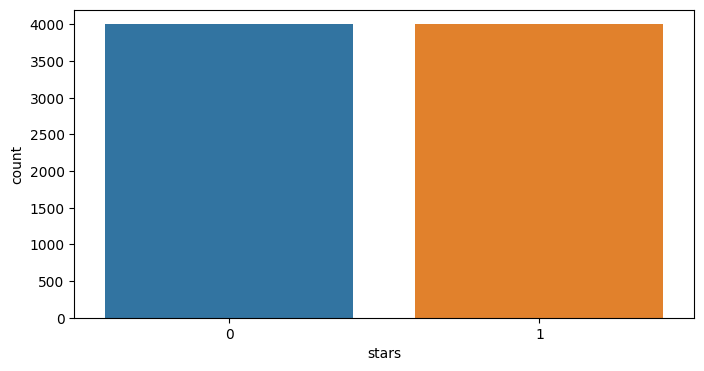

In [130]:
# Se revisa que la conversión que se hizo, se haya hecho de manera correcta
# Se espera que haya una clase 0 con 4000 reviews y una clase 1 con 4000 reviews
plt.figure(figsize=(8, 4))
sns.countplot( x = data.stars)
plt.show()

In [131]:
# Total de datos en el nuevo dataset
data.shape

(8000, 5)

In [132]:
data.head()

,stars,review_body,conteo_palabras,stopwords_conteo,segundo_conteo_palabras
0,0,grande demasiado mal protector,10,4,4
1,0,no recibido pedido no devolucion,8,3,5
2,0,buscar sistema no funciona bien lleva no bien ...,28,12,10
3,0,varias hacer presion interior peor compra hech...,52,28,9
4,0,no gusta olor aspecto malo,10,4,5


#### **Train test split**

Se hace el train test split donde se asigna 70% de los datos para entrenar y 30% de los datos para testeo.

In [133]:
# Se renombra con "X" la variable independiente y con "y" la variable target
X = data['review_body']
y = data['stars']

In [134]:
from sklearn.model_selection import train_test_split

X_train_binario, X_test_binario, y_train_binario, y_test_binario = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train_binario.shape, X_test_binario.shape, y_train_binario.shape, y_test.shape

((5600,), (2400,), (5600,), (3000,))

#### **Se aplica la lematización sobre cada conjunto de train y el conjunto de test**

In [135]:
%%time
# Se lematiza X_test
Xtest_lemma_binario = [lematizar_texto(i,lematizador=lematizador, limpiar = False) for i in X_test_binario]

CPU times: user 1min 58s, sys: 1.29 s, total: 1min 59s
Wall time: 1min 59s


In [137]:
# Se convierte el X_train lematizado a una serie de pandas
Xtest_binario = pd.Series(Xtest_lemma_binario)

In [138]:
Xtest_binario

0       articulo igual comodo boton tactil facilmente ...
1                                     cumplir espectativa
2                            no ajustar bien quedar borde
3       facil instalar proteger bien quitar dejar form...
4       mes haber llegar no llegar todavia esperar no ...
                              ...                        
2395       buen producto agradable durar bastante recomer
2396    correcto recomendable buen opcion tener cable ...
2397                 protector parecer buen solo no pegar
2398    gustar telefono ofrecer perfecto no primero mo...
2399    tener permitir comodo usar no dar sabor papel ...
Length: 2400, dtype: object

In [139]:
%%time
# Se lematiza X_train
Xtrain_lemma_binario = [lematizar_texto(i, lematizador=lematizador, limpiar = False) for i in X_train_binario]

CPU times: user 4min 46s, sys: 2.83 s, total: 4min 49s
Wall time: 4min 49s


In [141]:
# Se convierte el X_train lematizado a una serie de pandas
Xtrain_binario = pd.Series(Xtrain_lemma_binario)

In [142]:
Xtrain_binario

0                   buen producto buen precio limpio bien
1                          lampara no durar apenas semana
2       encontrar perfecto trabajo querer hacer no saludo
3       bastante contento comodo facil instalar rapido...
4          llegar producto tamaño color desastre devolver
                              ...                        
5595                                 tiempo aguantar agua
5596    baterir momento bien solo hora uso tiempo pode...
5597                            cristal llegado no iphone
5598                                     perfecto parecer
5599             no pesar limpio bien inconveniente ruido
Length: 5600, dtype: object

### **Aplicación de modelos con Vectorización TF-IDF**

Para este nuevo problema de Machine Learning se utilizará el método de vectorización TF-IDF, ya que fue el que presentó mejores resultados durante las pruebas en el problema anterior. 

#### **Modelo Base: LinearSVC con unigramas**

In [143]:
# Se instancia vectorizador tfidf con unigramas
# Se instancia modelo LinearSVC
# Se crea pipeline para incluir el procesamiento anterior
clf_b1 = Pipeline([('tfidf', TfidfVectorizer()), ('svc_clf', LinearSVC())], verbose=3)
clf_b1.fit(Xtrain_binario, y_train_binario)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s
[Pipeline] ........... (step 2 of 2) Processing svc_clf, total=   0.0s


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc_clf', LinearSVC())],
         verbose=3)

In [144]:
y_pred_b1 = clf_b1.predict(Xtest_binario)

In [145]:
print(classification_report(y_test_binario, y_pred_b1))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1246
           1       0.83      0.82      0.82      1154

    accuracy                           0.83      2400
   macro avg       0.83      0.83      0.83      2400
weighted avg       0.83      0.83      0.83      2400



**Conclusión:** Para este primer modelo base, se puede observar una significativa mejora respecto a los modelos aplicados en el problema anterior. Recordemos que el mejor modelo de predicción cuando el problema de clasificación tenía 5 clases fue de tan solo el 46%. Ahora que se están utilizando solo dos clases, el modelo base da una predicción del 83%. Esta predicción si se compara con el modelo base del problema anterior utilizando el mismo método de vectorización fue de 42%, lo cual es una diferencia bastante relevante.

#### **Segundo modelo:**

Igual que en el problema anterior, se hace un segundo modelo base utilizando LinearSVC, pero esta vez con el método TF-IDF incluyendo unigramas y bigramas, para ver cómo se comporta el resultado.

In [146]:
# Se instancia vectorizador tfidf con unigramas y bigramas
# Se instancia modelo LinearSVC
# Se crea pipeline para incluir el procesamiento anterior
clf_b2 = Pipeline([('tfidf_bngram', TfidfVectorizer(ngram_range=(1,2))), ('svc_clf_b2',LinearSVC())], verbose=3)
clf_b2.fit(Xtrain_binario, y_train_binario)

[Pipeline] ...... (step 1 of 2) Processing tfidf_bngram, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing svc_clf_b2, total=   0.0s


Pipeline(steps=[('tfidf_bngram', TfidfVectorizer(ngram_range=(1, 2))),
                ('svc_clf_b2', LinearSVC())],
         verbose=3)

In [147]:
y_pred_b2 = clf_b2.predict(Xtest_binario)

In [148]:
print(classification_report(y_test_binario, y_pred_b2))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1246
           1       0.84      0.84      0.84      1154

    accuracy                           0.85      2400
   macro avg       0.85      0.85      0.85      2400
weighted avg       0.85      0.85      0.85      2400



**Conclusión:** Para el segundo modelo base, se puede observar una leve pero importante mejora respecto al modelo anterior, es decir, cuando sólo se utilizaron unigramas. La métrica ahora arroja un resultado de 85% (dos puntos porcentuales más).

En términos generales, estos dos primeros resultados tienen un comportamiento similar a los resultados recibidos cuando se estaba clasificando las 5 clases, específicamente en lo que se refiere al impacto de utilizar unigramas y bigramas, en el cual para ambos casos el cambio no es significativo. 

#### **Optimización de hiperparámetros con GridSearchCV:** 

**Modelo RandomForest Classifier**

Luego de correr los primeros modelos, se hará una optimización de hiperparámetros utilizando un modelo Random Forest Classifier con el método de vectorización TF-IDF, teniendo en cuenta unigramas y bigramas.

In [149]:
# Se instancia TFIDF tomando en cuenta unigramas y bigramas
# Se instancia el modelo RandomForest
# Se crea pipeline de procesamiento con lo anterior

pipe_rfc_b3 = Pipeline(steps=[('tfidf_rfc', TfidfVectorizer(ngram_range=(1,2))),
                           ('clf_rfc', RandomForestClassifier(random_state=123))])

# Parámetros a optimizar
params_rfc = {'clf_rfc__n_estimators': [20,50],
              'clf_rfc__max_features':[5, 10, 20],
              'clf_rfc__max_depth': [None, 3, 10, 20],
              'clf_rfc__criterion': ['gini', 'entropy']}

# Validación Cruzada

grid_rfc_b3 = GridSearchCV(
    estimator = pipe_rfc_b3,
    param_grid = params_rfc,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
    refit = True, 
    verbose = 3,
    return_train_score = True
)

grid_rfc_b3.fit(Xtrain_binario, y_train_binario)

Fitting 15 folds for each of 48 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  8.4min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=Pipeline(steps=[('tfidf_rfc',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('clf_rfc',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'clf_rfc__criterion': ['gini', 'entropy'],
                         'clf_rfc__max_depth': [None, 3, 10, 20],
                         'clf_rfc__max_features': [5, 10, 20],
                         'clf_rfc__n_estimators': [20, 50]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [150]:
print("Mejores hiperparámetros encontrados (cv)")
print(grid_rfc_b3.best_params_, ":", grid_rfc_b3.best_score_, grid_rfc_b3.scoring)

Mejores hiperparámetros encontrados (cv)
{'clf_rfc__criterion': 'gini', 'clf_rfc__max_depth': None, 'clf_rfc__max_features': 20, 'clf_rfc__n_estimators': 50} : 0.8288095238095239 accuracy


In [151]:
modelo_final_b3 = grid_rfc_b3.best_estimator_

In [152]:
# Error de test del modelo final
y_pred_b3 = modelo_final_b3.predict(Xtest_binario)

In [153]:
print(classification_report(y_test_binario, y_pred_b3))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1246
           1       0.83      0.82      0.83      1154

    accuracy                           0.83      2400
   macro avg       0.83      0.83      0.83      2400
weighted avg       0.83      0.83      0.83      2400



**Conclusión:** 
Empleando un modelo de RandomForest y validación cruzada los mejores hiperparámetros son:
* criterion = gini
* max_depth = None 
* max_features= 20 
* n_estimators= 50

Se observa que este modelo no mejora mucho el resultado de la predicción respecto a los otros modelos que se han corrido desde que se planteó el problema binario, de hecho, arroja el mismo resultado que el primer modelo base (LinearSVC con vectorización TF-IDF unigramas).

#### **Optimización de hiperparámetros con GridSearchCV:** 

**Modelo GradientBoosting Classifier**

Ahora se correrá un modelo nuevo y diferente a los que hasta ahora se han hecho, para probar si se puede mejorar la predicción, suponiendo que los modelos de ensamble tienen en general mejor performance. Se trata del Modelo GradientBoosting Classifier. Se hará una optimización de hiperparámetros utilizando dicho modelo, con el método de vectorización TF-IDF, teniendo en cuenta unigramas y bigramas.

In [154]:
from sklearn.ensemble import GradientBoostingClassifier

In [155]:
pipe_gb_b4 = Pipeline(steps=[('tfidf_gb', TfidfVectorizer(ngram_range=(1,2))),
                           ('clf_gb', GradientBoostingClassifier(random_state=123))])

# Parámetros a optimizar
param_grid_gb_b4 = {'clf_gb__n_estimators'  : [50, 100],
              'clf_gb__max_features'  : [None, 10, 20, 30],
              'clf_gb__max_depth'     : [None, 3, 5, 10, 20],
              'clf_gb__subsample'     : [0.5, 1],
              'clf_gb__learning_rate' : [0.001, 0.01, 0.1]}

# Validación cruzada
grid_gb_b4 = GridSearchCV(
        estimator  = pipe_gb_b4,
        param_grid = param_grid_gb_b4,
        scoring    = 'accuracy',
        n_jobs     = - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 3,
        return_train_score = True
       )

grid_gb_b4.fit(Xtrain_binario, y_train_binario)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 62.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 71.8min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=123),
             estimator=Pipeline(steps=[('tfidf_gb',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('clf_gb',
                                        GradientBoostingClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'clf_gb__learning_rate': [0.001, 0.01, 0.1],
                         'clf_gb__max_depth': [None, 3, 5, 10, 20],
                         'clf_gb__max_features': [None, 10, 20, 30],
                         'clf_gb__n_estimators': [50, 100],
                         'clf_gb__subsample': [0.5, 1]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [156]:
print("Mejores hiperparámetros encontrados (cv)")
print(grid_gb_b4.best_params_, ":", grid_gb_b4.best_score_, grid_gb_b4.scoring)

Mejores hiperparámetros encontrados (cv)
{'clf_gb__learning_rate': 0.1, 'clf_gb__max_depth': None, 'clf_gb__max_features': 20, 'clf_gb__n_estimators': 100, 'clf_gb__subsample': 1} : 0.8392864694771051 accuracy


In [157]:
modelo_final_gb_b4 = grid_gb_b4.best_estimator_

In [158]:
y_pred_gb_b4 = modelo_final_gb_b4.predict(Xtest_binario)

In [159]:
print(classification_report(y_test_binario, y_pred_gb_b4))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1246
           1       0.83      0.83      0.83      1154

    accuracy                           0.84      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.84      0.84      0.84      2400



**Conclusión:** 
Empleando un modelo de GradientBoosting y validación cruzada los mejores hiperparámetros son:
* learning_rate = 0.1
* max_depth = None 
* max_features = 20 
* n_estimators = 100
* subsample = 1

Se observa que este modelo no mejora mucho el resultado de la predicción respecto a los otros modelos que se han corrido, obteniendo una predicción del 84%. 

#### **Optimización de hiperparámetros con GridSearchCV:** 

**Modelo: SVC utilizando Kernel RBF (Radial Basis Function)**

Se retoma el modelo SVC utilizando el kernel RBF utilizando optimización GridSearchCV, ya que hasta ahora ha sido el modelo que mejor performace ha tenido durante todo el proyecto, por tal razón, vale la pena ver su resultado. 

Se hará una optimización de hiperparámetros utilizando dicho modelo, con el método de vectorización TF-IDF, teniendo en cuenta unigramas y bigramas.

In [160]:
pipe_svc_rbf_b5 = Pipeline(steps=[('count_ngram', TfidfVectorizer(ngram_range=(1,2))),
                                  ('svc_rbf_b5', SVC(kernel='rbf', random_state=123))])

# Parámetros a optimizar
params_svc_rbf_b5 = {'svc_rbf_b5__gamma': [0.01, 1, 10.0],
                     'svc_rbf_b5__C':[1, 10, 20, 100, 1000]}

# Validación Cruzada

grid_svc_rbf_b5= GridSearchCV(
    estimator = pipe_svc_rbf_b5,
    param_grid = params_svc_rbf_b5,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
    refit = True, 
    verbose = 3,
    return_train_score = True
)

grid_svc_rbf_b5.fit(Xtrain_binario, y_train_binario)

Fitting 15 folds for each of 15 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 14.3min finished


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=Pipeline(steps=[('count_ngram',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('svc_rbf_b5', SVC(random_state=123))]),
             n_jobs=-1,
             param_grid={'svc_rbf_b5__C': [1, 10, 20, 100, 1000],
                         'svc_rbf_b5__gamma': [0.01, 1, 10.0]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [161]:
# Mejores hiperparámetros por validación cruzada
print("Mejores hiperparámetros encontrados por validación cruzada")
print(grid_svc_rbf_b5.best_params_, ":", grid_svc_rbf_b5.best_score_, grid_svc_rbf_b5.scoring)

Mejores hiperparámetros encontrados por validación cruzada
{'svc_rbf_b5__C': 1, 'svc_rbf_b5__gamma': 1} : 0.8490476190476189 accuracy


In [162]:
modelo_final_svc_rbf_b5 = grid_svc_rbf_b5.best_estimator_

In [163]:
y_pred_svc_rbf_b5 = modelo_final_svc_rbf_b5.predict(Xtest_binario)

In [164]:
print(classification_report(y_test_binario, y_pred_svc_rbf_b5))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1246
           1       0.86      0.83      0.84      1154

    accuracy                           0.85      2400
   macro avg       0.85      0.85      0.85      2400
weighted avg       0.85      0.85      0.85      2400



**Conclusión:** Empleando un modelo de SVC kernel RBF y validación cruzada, los mejores hiperparámetros son: C= 1 y gamma= 1. Con estos hiperparámetros se consigue una predicción del 85%, que es el mejor resultado obtenido hasta ahora junto con el resultado del segundo modelo que se aplicó en esta fase (modelo LinearSVC).

Ahora sobre este modelo, se hará la matriz de confusión para concluir más detalles.

In [165]:
print("Matriz de confusión")
pd.DataFrame(confusion_matrix(y_test_binario, y_pred_svc_rbf_b5),
             columns= ["Etiqueta 0", "Etiqueta 1"],
             index = ["Etiqueta 0", "Etiqueta 1"])

Matriz de confusión


,Etiqueta 0,Etiqueta 1
Etiqueta 0,1087,159
Etiqueta 1,196,958


Con el resultado de la matriz de confusión se puede concluir que el modelo clasifica de manera errada 355 reviews de un total de 2400, es decir, tiene un procentaje de error del 14,7%.

#### **Se hace la predicción de algunas frases de prueba**

Se hacen algunas pruebas sobre el modelo seleccionado para comprobar qué tan bien clasifica. Aunque hay que tener en cuenta que las frases no se han sometido al pre-procesamiento de texto (limpieza) y lematización que debería hacerse antes de incluirlas dentro de nuestro modelo, el cual aprendió con texto pre-procesado, es decir, cada vez que entreguemos datos nuevos al modelo, debemos aplicar el mismo pre-procesamiento que se hizo al principio de este proyecto. De igual manera, vamos a probar qué tan bien lo hace. 

Vale la pena recordar que las etiquetas que se definieron fue cero (0) para reviews negativas, y de uno (1) para reviews positivas.

In [166]:
modelo_final_svc_rbf_b5.predict(['me siento completamente estafada'])

array([0])

In [167]:
modelo_final_svc_rbf_b5.predict(['me gusta aunque podrían mejorar la entrega'])

array([1])

In [168]:
modelo_final_svc_rbf_b5.predict(['mi hija se puso feliz, es muy bueno'])

array([1])

In [169]:
# Probemos con una frase que no es completamente positiva
# Se esperaría que el modelo la clasifique dentro de la clase positiva (1)
modelo_final_svc_rbf_b5.predict(['la verdad el producto es bueno pero tenía más expectativas'])

array([1])

In [170]:
modelo_final_svc_rbf_b5.predict(['me pareció muy costoso, la verdad pueden comprarse otra cosa mejor con el mismo dinero'])

array([0])

In [171]:
modelo_final_svc_rbf_b5.predict(['no me atendieron oportunamente'])

array([0])

In [174]:
modelo_final_svc_rbf_b5.predict(['todo estuvo bien, no tengo queja alguna'])

array([0])

En el ejemplo anterior, el modelo se equivocó ya que calificó mal una review que era positiva. Pudo suceder que el modelo encuentra una frase positiva planteada con palabras comunmente usadas en las frases negativas como lo es "no tengo queja alguna"). El modelo seguramente tomó las palabras "no" y "queja" las cuales habitualmente se encuentran en reviews negativas y pudo haber confundido al modelo.

In [179]:
modelo_final_svc_rbf_b5.predict(['los huevos me llegaron rotos y no me han devuelto mi dinero'])

array([0])

In [180]:
# Probemos con una frase sarcástica 
# Se espera que el modelo lo clasifique dentro de la clase negativa (0)
modelo_final_svc_rbf_b5.predict(['por lo que veo el producto me llegará cuando se acabe la pandemia'])

array([0])

## 6. Conclusiones Generales

A continuación se pueden observar de manera comparativa, todos los resultados obtenidos con los diferentes modelos y métodos de vectorización utilizados:

**PROBLEMA CON 5 CLASES - MÉTODO VECTORIZACIÓN TF-IDF:**

* Modelo LinearSVC unigramas: 42%
* Modelo LinearSVC unigramas y bigramas: 43%
* Modelo LinearSVC bigramas: 37%
* Optimización GridSearchCV Modelo RamdomForest unigramas y bigramas: 40%
* Optimización GridSearchCV Modelo SVC kernel RBF unigramas y bigramas: 46%

**PROBLEMA CON 5 CLASES - MÉTODO VECTORIZACIÓN BOW:**

* Modelo LinearSVC unigramas: 42%
* Modelo LinearSVC unigramas y bigramas: 41%
* Modelo LinearSVC bigramas: 36%
* Optimización GridSearchCV Modelo SVC kernel RBF unigramas optimizado: 44%

**PROBLEMA BINARIO - MÉTODO VECTORIZACIÓN TF-IDF:**

* Modelo LinearSVC unigramas: 83%
* Modelo LinearSVC unigramas y bigramas: 85%
* Optimización GridSearchCV Modelo RamdomForest unigramas y bigramas optimizado: 83%
* Optimización GridSearchCV Modelo GradientBoostingClassifier unigramas y bigramas optimizado: 84%
* Optimización GridSearchCV Modelo SVC kernel RBF unigramas y bigramas optimizado: 85%

Basado en los resultados comparativos anteriores, podemos llegar a las siguientes conclusiones:

* Siempre que el problema fue planteado con las 5 clases, es decir, con la clasificación para 1, 2, 3, 4 y 5 estrellas, las predicciones fueron bastante bajas, independientemente del Método de Vectorización y los Modelos utilizados. Dichos resultados, en el mejor de los escenarios estuvieron en el 46% y en el peor de los escenarios estuvieron en el 36%, predicciones que son demasiado bajas.

* Al aplicar el Método de Vectorización TF-IDF sobre el problema estructurado de forma "binaria", es decir, agrupando solamente en dos clases (0 y 1) las reviews, el modeo pudo predecir con muchísima más precisión los resultados llegando a un 85%. Para ello se decidió agrupar como clase cero (0) aquellas clasificaciones con 1 y 2 estrellas y agrupar como clase uno (1) aquellas clasificaciones con 4 y 5 estrellas. Se desecharon las clasificaciones con 3 estrellas ya que se consideró que las personas que usan este tipo de clasificaciones no adoptan una posición concreta como tal.

* No se aplicó el Método de Vectorización BOW sobre el problema estructurado de forma "binaria", ya que los resultados que se habían obtenido cuando se enfocó el problema con 5 clases, fueron más bajos que los obtenidos con el Método de Vectorización TF-IDF.

* Finalmente, para resolver el problema binario, el modelo seleccionado fue el Modelo SVC con kernel RBF utilizando el Método de Vectorización TF-IDF, ya que arrojó el resultado más alto del 85%.

* Se considera que el márgen de error del 15% que tiene el modelo seleccionado, se debe entre otras cosas a que en ocasiones las personas pueden llegar a utilizar palabras que habitualmente hacen parte de las opiniones negativas dentro de la estructura de una opinión positiva o visceversa. Por ejemplo, cuando una persona opina "no tengo queja alguna", que es una opinión altamente positiva y que debería el modelo predecirlo con un 4 o un 5, contrariamente termina prediciéndolo con un 1 o 2 ya que habitualmente la palabra "no" y la palabra "queja", son más comunmente utilizadas en contextos negativos que positivos.  